In [1]:
import numpy as np
import math
import msprime
import tsinfer
import logging
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from ast import literal_eval as make_tuple
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore",message="numpy.dtype size changed")
from scipy.special import comb
from collections import defaultdict 
import random
import subprocess
import pickle
from IPython.display import SVG

from collections import OrderedDict
import matplotlib.pyplot as plt

/home/wilderwohns/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
analytical_result_51 = np.reshape(np.loadtxt("/home/wilderwohns/analytical_ordering/analytical_predictions(51, 51, 51, 51).txt"),(51,51,51,51))

In [3]:
def make_errors(g, p):
    """
    Resample for a specific variant, whose genotypes g are passed in
    For each sample an error occurs with probability p. Errors are generated by
    sampling values from the stationary distribution, that is, if we have an
    allele frequency of f, a 1 is emitted with probability f and a
    0 with probability 1 - f. Thus, there is a possibility that an 'error'
    will in fact result in the same value.
    """
    w = np.copy(g)
    if p > 0:
        m = g.shape[0]
        frequency = np.sum(g) / m
        # Randomly choose samples with probability p
        samples = np.where(np.random.random(m) < p)[0]
        # Generate observations from the stationary distribution.
        errors = (np.random.random(samples.shape[0]) < frequency).astype(int)
        w[samples] = errors
    return w

In [4]:
def generate_samples(ts, filename, real_error_rate=0,no_error=False):
    """
    Generate a samples file from a simulated ts
    Samples may have bits flipped with a specified probability.
    (reject any variants that result in a fixed column)
    """
    append_filename =""
    if no_error == True:
        append_filename = "_no_error"
   
    if real_error_rate > 0:
        logging.debug("converting real error rate to an error param by multiplying by log(n)")
    error_param = real_error_rate * math.log(ts.num_samples)
    record_rate = logging.getLogger().isEnabledFor(logging.INFO)
    n_variants = bits_flipped = 0
    assert ts.num_sites != 0
    
    sample_data = tsinfer.SampleData(path="../data/"+filename + "/"+filename+append_filename+".samples", sequence_length=ts.sequence_length)
    for v in ts.variants():
        n_variants += 1
        if error_param <=0:
            sample_data.add_site(
                position=v.site.position, alleles=v.alleles,
                genotypes=v.genotypes)
        else:
            #make new genotypes with error
            # Reject any columns that have no 1s or no zeros.
            # Unless the original also has them, as occasionally we have
            # some sims (e.g. under selection) where a variant is fixed
            while True:
                genotypes = make_errors(v.genotypes, error_param)
                s = np.sum(genotypes)
                if 0 < s < ts.sample_size:
                    break
                if s == np.sum(v.genotypes):
                    break
            if record_rate:
                bits_flipped += np.sum(np.logical_xor(genotypes, v.genotypes))
            sample_data.add_site(
                position=v.site.position, alleles=v.alleles,
                genotypes=genotypes)
    if real_error_rate>0:
        logging.info("Error of {} injected into {}".format(real_error_rate, os.path.basename(filename))
            + ": actual error rate = {} (error param = {})".format(
                bits_flipped/(n_variants*ts.sample_size), error_param) if record_rate else "")
    sample_data.finalise()
    return sample_data


In [5]:
def make_errors_genotype_model(g, error_matrix):
    """
    Given an empirically estimated error matrix, resample for a particular
    variant. Given a true genotype of g0, g1, or g2, return observed genotype
    depending on the error_matrix. For example, given a variant with genotype
    g0, return g0 with probability 99.942%, g1 with probability 0.041%, and
    g2 with probability 0.017%. Treat each pair of alleles as a diploid 
    individual. 
    """
    w = np.copy(g)
    #Make diploid (iterate each pair of alleles)
    genos=[(w[i],w[i+1]) for i in range(0,w.shape[0],2)]
    #Record the true genotypes
    g0 = [i for i, x in enumerate(genos) if x == (0,0)]
    g1a = [i for i, x in enumerate(genos) if x == (1,0)]
    g1b = [i for i, x in enumerate(genos) if x == (0,1)]
    g2 = [i for i, x in enumerate(genos) if x == (1,1)]

    for idx in g0:
              
        result=random.choices([(0,0),(1,0),(1,1)], weights=error_matrix[['p00','p01','p02']].values[0])[0]
        if result == (1,0):
            genos[idx]=random.choices([(0,1),(1,0)])[0]
        else:
            genos[idx] = result

    for idx in g1a:
        genos[idx]=random.choices([(0,0),(1,0),(1,1)], weights=error_matrix[['p10','p11','p12']].values[0])[0]

    for idx in g1b:
        genos[idx]=random.choices([(0,0),(0,1),(1,1)], weights=error_matrix[['p10','p11','p12']].values[0])[0]
        
    for idx in g2:
        result=random.choices([(0,0),(1,0),(1,1)], weights=error_matrix[['p20','p21','p22']].values[0])[0]
        
        if result == (1,0):
            genos[idx]=random.choices([(0,1),(1,0)])[0]
        else:
            genos[idx] = result  
    return(np.array(sum(genos, ())))

In [6]:
def generate_samples_genotype(ts, filename):
    """
    Generate a samples file from a simulated ts
    (reject any variants that result in a fixed column)
    """
    error_matrix=pd.read_csv("/home/wilderwohns/relative_allele_age/data/result.profile.1000g.platinum.empirical.csv")
    record_rate = logging.getLogger().isEnabledFor(logging.INFO)
    n_variants = bits_flipped = 0
    assert ts.num_sites != 0
    sample_data = tsinfer.SampleData(path="../data/"+filename + "/"+filename+".samples", sequence_length=ts.sequence_length)
    for v in ts.variants():
        n_variants += 1


        #Record the allele frequency
        m = v.genotypes.shape[0]
        frequency = np.sum(v.genotypes) / m
        #Find closest row in error matrix file
        closest_freq = error_matrix.iloc[(error_matrix['freq']-frequency).abs().argsort()[:1]]
       
        #make new genotypes with error
        # Reject any columns that have no 1s or no zeros.
        # Unless the original also has them, as occasionally we have
        # some sims (e.g. under selection) where a variant is fixed
        while True:
            genotypes = make_errors_genotype_model(v.genotypes,closest_freq)
            s = np.sum(genotypes)
            break
        if record_rate:
            bits_flipped += np.sum(np.logical_xor(genotypes, v.genotypes))
        sample_data.add_site(
            position=v.site.position, alleles=v.alleles,
            genotypes=genotypes)
  
    logging.info(": actual error rate = {}".format(
            bits_flipped/(n_variants*ts.sample_size)) if record_rate else "")
    sample_data.finalise()
    return sample_data

In [7]:
import math
def out_of_africa():
    # First we set out the maximum likelihood values of the various parameters
    # given in Table 1.
    N_A = 7300
    N_B = 2100
    N_AF = 12300
    N_EU0 = 1000
    N_AS0 = 510
    # Times are provided in years, so we convert into generations.
    generation_time = 25
    T_AF = 220e3 / generation_time
    T_B = 140e3 / generation_time
    T_EU_AS = 21.2e3 / generation_time
    # We need to work out the starting (diploid) population sizes based on
    # the growth rates provided for these two populations
    r_EU = 0.004
    r_AS = 0.0055
    N_EU = N_EU0 / math.exp(-r_EU * T_EU_AS)
    N_AS = N_AS0 / math.exp(-r_AS * T_EU_AS)
    # Migration rates during the various epochs.
    m_AF_B = 25e-5
    m_AF_EU = 3e-5
    m_AF_AS = 1.9e-5
    m_EU_AS = 9.6e-5
    # Population IDs correspond to their indexes in the population
    # configuration array. Therefore, we have 0=YRI, 1=CEU and 2=CHB
    # initially.
    return dict(
        population_configurations = [
            msprime.PopulationConfiguration(
                sample_size=16, initial_size=N_AF),
            msprime.PopulationConfiguration(
                sample_size=16, initial_size=N_EU, growth_rate=r_EU),
            msprime.PopulationConfiguration(
                sample_size=16, initial_size=N_AS, growth_rate=r_AS)
        ],
        migration_matrix = [
            [      0, m_AF_EU, m_AF_AS],
            [m_AF_EU,       0, m_EU_AS],
            [m_AF_AS, m_EU_AS,       0],
        ],
        demographic_events = [
            # CEU and CHB merge into B with rate changes at T_EU_AS
            msprime.MassMigration(
                time=T_EU_AS, source=2, destination=1, proportion=1.0),
            msprime.MigrationRateChange(time=T_EU_AS, rate=0),
            msprime.MigrationRateChange(
                time=T_EU_AS, rate=m_AF_B, matrix_index=(0, 1)),
            msprime.MigrationRateChange(
                time=T_EU_AS, rate=m_AF_B, matrix_index=(1, 0)),
            msprime.PopulationParametersChange(
                time=T_EU_AS, initial_size=N_B, growth_rate=0, population_id=1),
            # Population B merges into YRI at T_B
            msprime.MassMigration(
                time=T_B, source=1, destination=0, proportion=1.0),
            # Size changes to N_A at T_AF
            msprime.PopulationParametersChange(
                time=T_AF, initial_size=N_A, population_id=0)
        ]
    )
        
    # Use the demography debugger to print out the demographic history
    # that we have just described.
#     dd = msprime.DemographyDebugger(
#         population_configurations=population_configurations,
#         migration_matrix=migration_matrix,
#         demographic_events=demographic_events)
#     dd.print_history()

In [8]:
#I compared with geva_age_estimate and it's good
def geva_with_error(sample_data,Ne,length,mut_rate):
    
    num_individuals = len(sample_data.individuals_metadata[:])
    ind_list = list()
    pos_geno_dict = {"POS":list()}

    for i in range(int(num_individuals/2)):
        pos_geno_dict["msp_"+str(i)] = list()
        ind_list.append("msp_"+str(i))

    #add all the sample positions and genotypes
    for i in sample_data.genotypes():
        pos_geno_dict["POS"].append(int(round(sample_data.sites_position[i[0]])))
        for j in range(0,len(i[1]),2):

            pos_geno_dict["msp_"+str(int(j/2))].append(str(i[1][j]) + "|" + str(i[1][j+1]))

    df = pd.DataFrame(pos_geno_dict)

    df["#CHROM"] = 1
    df["REF"] = "A"
    df["ALT"] = "T"
    df['ID'] = "."
    df['QUAL'] = "."
    df['FILTER'] = "PASS"
    df['INFO'] = "."
    df['FORMAT'] = "GT"

    cols = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO','FORMAT']+ind_list
    df = df[cols] 

    header = """##fileformat=VCFv4.2
##source=msprime 0.6.0
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=""" + str(int(length)) +  """>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
"""
    
    output_VCF = "../tmp/error.vcf"
    with open(output_VCF, 'w') as vcf:
        vcf.write(header)

    df.to_csv(output_VCF, sep="\t", mode='a',index=False)
    
    return(geva_age_estimate("../tmp/error",10000,2e-8))



In [347]:
agree_overall_distances = list()
disagree_overall_distances = list()
baseline_overall_distances = list()

In [348]:
agree_overall_freq_diff = list()
disagree_overall_freq_diff = list()
baseline_overall_freq_diff = list()

In [349]:
distance_freq = list()

In [350]:
freq_not_equal = list()
freq_equal = list()

In [351]:
analytical_prediction_bins = defaultdict(list)
analytical_prediction_bins_equal  = defaultdict(list)

In [363]:
"""
2000 Simulations without error, calculate freq does not equal age
"""
for i in tqdm(range(0,2000,1)):
    total=0
    agree=0
    disagree=0
    no_marked =0
    
    distance=0
    simulation = msprime.simulate(sample_size=50, Ne=10000, length=150000, recombination_rate=2e-8, mutation_rate=2e-8)
    #simulation = msprime.simulate(**out_of_africa(),length=150000, recombination_rate=2e-8, mutation_rate=2e-8)
    
    ### GEVA ADDED PART####
#     with open("../tmp/"+name+".vcf", "w") as vcf_file:
#         simulation.write_vcf(vcf_file, 2)
    #########
    
    
    sample_data=generate_samples(simulation,"test",0,True)
    
    num_mutations = len(sample_data.sites_genotypes[:])

    variant_ages = [(mutation.id,simulation.node(mutation.node).time) for mutation in list(simulation.mutations())]
    variant_frequencies = [len(geno[geno==1])/len(geno) for geno in sample_data.sites_genotypes[:]]
    variant_nums = [len(geno[geno==1]) for geno in sample_data.sites_genotypes[:]]
    mutation_positions=[mutation.position for mutation in list(simulation.mutations())]


    for combo in list(itertools.combinations(range(0,num_mutations),2)):
        total += 1
        age1 = variant_ages[combo[0]]
        age2 = variant_ages[combo[1]]
        freq1 = variant_frequencies[combo[0]]
        freq2 = variant_frequencies[combo[1]]
        freq_diff = abs(freq1 - freq2)
        distance = abs(mutation_positions[combo[0]] - mutation_positions[combo[1]])
        distance_freq.append((distance,freq_diff))
        
        if (freq1 != freq2) and (freq1 != 1/50) and (freq2 != 1/50):
            
            baseline_overall_distances.append(distance)
            baseline_overall_freq_diff.append(freq_diff)
            if ((age1[1] <= age2[1]) == (freq1 <= freq2)):
                agree+=1
                agree_overall_freq_diff.append(freq_diff)
                agree_overall_distances.append(distance)
                
            else:
                disagree+=1
                disagree_overall_freq_diff.append(freq_diff)
                disagree_overall_distances.append(distance)
            
            if variant_nums[combo[0]] < variant_nums[combo[1]]:
               
                analytical_prediction_bins[int(distance/2000)].append(analytical_result_51[variant_nums[combo[0]],50-variant_nums[combo[0]],variant_nums[combo[1]],50-variant_nums[combo[1]]])
            else: 
                analytical_prediction_bins[int(distance/2000)].append(analytical_result_51[variant_nums[combo[1]],50-variant_nums[combo[1]],variant_nums[combo[0]],50-variant_nums[combo[0]]])
                
            freq_not_equal.append((distance,freq_diff))
        
        #else:
        elif (freq1 != 1/50) and (freq2 != 1/50):
            if (random.choice([True, False])):
                agree+=1
                agree_overall_freq_diff.append(freq_diff)
                agree_overall_distances.append(distance)
                
            else:
                disagree+=1
                disagree_overall_freq_diff.append(freq_diff)
                disagree_overall_distances.append(distance)
                
            baseline_overall_distances.append(distance)
            baseline_overall_freq_diff.append(freq_diff)
            analytical_prediction_bins[int(distance/2000)].append(analytical_result_51[variant_nums[combo[0]],50-variant_nums[combo[0]],variant_nums[combo[1]],50-variant_nums[combo[1]]])

                
        
        
       


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Exception in thread Thread-24:
Traceback (most recent call last):
  File "/home/wilderwohns/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/wilderwohns/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/wilderwohns/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: 

In [364]:
bins_freq_diff = np.linspace(0,1,21)
digitized_agree_freq_diff = np.digitize(agree_overall_freq_diff, bins_freq_diff)
digitized_disagree_freq_diff = np.digitize(disagree_overall_freq_diff, bins_freq_diff)
digitized_baseline_freq_diff = np.digitize(baseline_overall_freq_diff, bins_freq_diff)

agree_counts_freq_diff = np.unique(digitized_agree_freq_diff, return_counts=True)
disagree_counts_freq_diff = np.unique(digitized_disagree_freq_diff, return_counts=True)
baseline_counts_freq_diff = np.unique(digitized_baseline_freq_diff, return_counts=True)

results_freq_diff = [agree_counts_freq_diff[1][agree_counts_freq_diff[0] == count[0]][0]/count[1] for count in zip(baseline_counts_freq_diff[0],baseline_counts_freq_diff[1]) if count[0] in agree_counts_freq_diff[0]]

digitized_baseline_freq_diff_error = np.digitize(baseline_overall_freq_diff_error, bins_freq_diff)
digitized_disagree_freq_diff_error = np.digitize(disagree_overall_freq_diff_error, bins_freq_diff)
digitized_agree_freq_diff_error = np.digitize(agree_overall_freq_diff_error, bins_freq_diff)

agree_counts_freq_diff_error = np.unique(digitized_agree_freq_diff_error, return_counts=True)
disagree_counts_freq_diff_error = np.unique(digitized_disagree_freq_diff_error, return_counts=True)
baseline_counts_freq_diff_error = np.unique(digitized_baseline_freq_diff_error, return_counts=True)

results_freq_diff_error = [agree_counts_freq_diff_error[1][agree_counts_freq_diff_error[0] == count[0]][0]/count[1] for count in zip(baseline_counts_freq_diff_error[0],baseline_counts_freq_diff_error[1]) if count[0] in agree_counts_error[0]]


In [381]:
for item in distance_freq:
    if item[0] > 145000:
        print(item)

(145346.64748531426, 0.06)
(145439.21492697168, 0.22)
(145482.72011386973, 0.22)
(146619.75026490656, 0.13999999999999999)
(146653.9416250261, 0.13999999999999999)
(146860.31197570128, 0.07999999999999999)
(147307.52824972957, 0.22)
(147577.46699965914, 0.13999999999999999)
(148417.05900945442, 0.18)
(148920.9321808813, 0.10000000000000003)
(148976.1870343767, 0.13999999999999999)
(149078.3050878908, 0.10000000000000003)
(149763.38301438946, 0.24)
(149867.19473059784, 0.24)
(145836.2804893364, 0.68)
(145870.47184945596, 0.68)
(146076.84220013113, 0.62)
(146524.05847415942, 0.76)
(146793.997224089, 0.68)
(147633.58923388427, 0.72)
(148137.46240531115, 0.44)
(148192.71725880654, 0.68)
(148294.83531232065, 0.44)
(148979.9132388193, 0.30000000000000004)
(149083.7249550277, 0.30000000000000004)
(145795.24013597862, 0.12)
(145829.43149609817, 0.12)
(146035.80184677333, 0.06)
(146483.01812080163, 0.2)
(146752.9568707312, 0.12)
(147592.54888052648, 0.16)
(148096.42205195336, 0.1200000000000000

(145168.08511919732, 0.52)
(145915.10138295311, 0.26)
(146042.82141402565, 0.26)
(146354.99343526264, 0.32)
(147137.83659662926, 0.33999999999999997)
(147810.94447791565, 0.33999999999999997)
(148171.7903352573, 0.33999999999999997)
(148401.89128540794, 0.21999999999999997)
(148486.35597106602, 0.06)
(148767.8671835863, 0.33999999999999997)
(149091.35676620834, 0.26)
(149215.59603689463, 0.32)
(145741.88989904226, 0.020000000000000004)
(145869.6099301148, 0.020000000000000004)
(146181.7819513518, 0.04)
(146964.6251127184, 0.06)
(147637.7329940048, 0.06)
(147998.57885134645, 0.06)
(148228.67980149708, 0.06000000000000001)
(148313.14448715516, 0.21999999999999997)
(148594.65569967544, 0.06)
(148918.14528229748, 0.020000000000000004)
(149042.38455298377, 0.04)
(145502.9155130025, 0.36)
(145630.63554407502, 0.36)
(145942.80756531202, 0.42000000000000004)
(146725.65072667864, 0.44)
(147398.75860796502, 0.44)
(147759.60446530668, 0.44)
(147989.7054154573, 0.32)
(148074.1701011154, 0.16000000

(145370.7917866104, 0.96)
(145449.66277407279, 0.9)
(146596.5870927942, 0.62)
(146675.78195074212, 0.45999999999999996)
(147112.3559003115, 0.8)
(147228.6406627719, 0.96)
(147285.3980786226, 0.86)
(147540.69092787037, 0.86)
(148183.74063669535, 0.9199999999999999)
(148584.62367102987, 0.88)
(145347.83882224595, 0.96)
(145426.70980970832, 0.9)
(146573.63412842972, 0.62)
(146652.82898637766, 0.45999999999999996)
(147089.40293594703, 0.8)
(147205.68769840745, 0.96)
(147262.44511425812, 0.86)
(147517.7379635059, 0.86)
(148160.7876723309, 0.9199999999999999)
(148561.6707066654, 0.88)
(145784.81120861133, 0.33999999999999997)
(145864.00606655926, 0.5)
(146300.58001612863, 0.16)
(146416.86477858905, 0.0)
(146473.62219443973, 0.09999999999999999)
(146728.9150436875, 0.09999999999999999)
(147371.9647525125, 0.039999999999999994)
(147772.847786847, 0.08)
(145180.94835587867, 0.27999999999999997)
(145260.1432138266, 0.44)
(145696.71716339598, 0.09999999999999999)
(145813.0019258564, 0.06)
(145869

(145713.78090297244, 0.02)
(146611.55731678312, 0.1)
(146718.52475609948, 0.060000000000000005)
(147148.09687615064, 0.04)
(147333.2840583487, 0.019999999999999997)
(147372.56740440772, 0.94)
(147442.49155188314, 0.02)
(147517.00119116728, 0.7799999999999999)
(147726.6779466245, 0.019999999999999997)
(147729.1730145118, 0.7799999999999999)
(148254.96146993453, 0.28)
(148721.8669565453, 0.019999999999999997)
(149004.32662246632, 0.02)
(149095.3168886713, 0.94)
(149159.43544061336, 0.6799999999999999)
(149490.37535215128, 0.04)
(149528.5340766333, 0.02)
(145667.7962261133, 0.06)
(146565.57263992398, 0.06000000000000001)
(146672.54007924034, 0.020000000000000004)
(147102.1121992915, 0.0)
(147287.29938148957, 0.020000000000000004)
(147326.58272754858, 0.9)
(147396.506875024, 0.06)
(147471.01651430814, 0.74)
(147680.69326976535, 0.020000000000000004)
(147683.18833765265, 0.74)
(148208.9767930754, 0.24)
(148675.88227968616, 0.020000000000000004)
(148958.3419456072, 0.06)
(149049.33221181217,

(147029.19532399575, 0.03999999999999998)
(147035.33342763525, 0.24000000000000002)
(147104.48329021028, 0.12)
(147109.9353378131, 0.08000000000000002)
(147132.01946758226, 0.24000000000000002)
(145448.17829770566, 0.16)
(145496.5949873224, 0.0)
(145794.6158273891, 0.6799999999999999)
(145983.71644750578, 0.6799999999999999)
(146104.43794321222, 0.039999999999999994)
(146234.1226723295, 0.27999999999999997)
(146240.260775969, 0.0)
(146309.41063854404, 0.12000000000000001)
(146314.86268614687, 0.16)
(146336.94681591602, 0.0)
(145229.0669059027, 0.16000000000000003)
(145277.48359551944, 0.32)
(145575.50443558613, 0.35999999999999993)
(145764.60505570282, 0.35999999999999993)
(145885.32655140926, 0.28)
(146015.01128052655, 0.040000000000000036)
(146021.14938416606, 0.32)
(146090.29924674108, 0.2)
(146095.7512943439, 0.16000000000000003)
(146117.83542411306, 0.32)
(145147.21256406236, 0.48000000000000004)
(145195.6292536791, 0.64)
(145493.6500937458, 0.039999999999999925)
(145682.750713862

(145029.31577649125, 0.07999999999999999)
(145041.67267133182, 0.86)
(145374.04334902627, 0.86)
(145769.1056389011, 0.1)
(146487.19764679042, 0.02)
(148082.09729025114, 0.0)
(149248.20946282893, 0.32)
(149301.1249019724, 0.02)
(149435.4176974717, 0.02)
(149472.69551592245, 0.32)
(149557.20476766754, 0.019999999999999997)
(149651.96438999815, 0.019999999999999997)
(149677.5562470788, 0.36000000000000004)
(149729.60982088465, 0.02)
(145157.28573597447, 0.54)
(145552.3480258493, 0.21999999999999997)
(146270.44003373862, 0.33999999999999997)
(147865.33967719934, 0.32)
(149031.45184977714, 0.0)
(149084.3672889206, 0.33999999999999997)
(149218.6600844199, 0.33999999999999997)
(149255.93790287065, 0.0)
(149340.44715461574, 0.3)
(149435.20677694635, 0.3)
(149460.798634027, 0.040000000000000036)
(149512.85220783285, 0.33999999999999997)
(145035.7961791812, 0.12000000000000001)
(145753.88818707052, 0.0)
(147348.78783053125, 0.02)
(148514.90000310904, 0.33999999999999997)
(148567.8154422525, 0.0)

(145138.74832085252, 0.14)
(145457.8772617541, 0.36)
(146001.66015534874, 0.30000000000000004)
(146188.2750790714, 0.48000000000000004)
(146471.86106711067, 0.48000000000000004)
(146521.74193294285, 0.38)
(146560.3471090923, 0.38)
(146610.51360880974, 0.38)
(147341.06283701485, 0.52)
(147409.35378829815, 0.30000000000000004)
(147616.59814681037, 0.05999999999999994)
(147831.6881758101, 0.30000000000000004)
(147839.59763369616, 0.30000000000000004)
(147961.2764489856, 0.48000000000000004)
(148125.40456405326, 0.44000000000000006)
(148515.3639526416, 0.5)
(148623.51279991685, 0.36)
(145013.77287980303, 0.86)
(145557.55577339767, 0.19999999999999998)
(145744.17069712034, 0.019999999999999997)
(146027.7566851596, 0.019999999999999997)
(146077.63755099179, 0.12)
(146116.24272714125, 0.12)
(146166.40922685867, 0.12)
(146896.95845506378, 0.02)
(146965.24940634708, 0.19999999999999998)
(147172.4937648593, 0.5599999999999999)
(147387.58379385903, 0.19999999999999998)
(147395.4932517451, 0.19999

(145354.70560912773, 0.56)
(145399.31497158634, 0.16000000000000003)
(145612.82669180815, 0.64)
(145685.2285249944, 0.84)
(145754.1748591911, 0.74)
(145971.32438237336, 0.82)
(146129.2950235771, 0.16000000000000003)
(146386.99288350253, 0.16000000000000003)
(146660.89832798124, 0.84)
(146969.49873649128, 0.64)
(147000.21161533706, 0.84)
(147076.07240033086, 0.14)
(147292.80905448325, 0.58)
(147795.87151191683, 0.58)
(148169.62965154325, 0.58)
(145007.84614022032, 0.5399999999999999)
(145086.47159474457, 0.13999999999999999)
(145131.08095720317, 0.5399999999999999)
(145344.59267742498, 0.06)
(145416.99451061123, 0.14)
(145485.94084480792, 0.04000000000000001)
(145703.0903679902, 0.12)
(145861.06100919395, 0.5399999999999999)
(146118.75886911937, 0.5399999999999999)
(146392.66431359807, 0.14)
(146701.2647221081, 0.06)
(146731.9776009539, 0.14)
(146807.8383859477, 0.5599999999999999)
(147024.57504010008, 0.12000000000000002)
(147527.63749753367, 0.12000000000000002)
(147901.39563716008, 0

(145694.3078788442, 0.06)
(145813.72916279966, 0.06)
(146177.5492230337, 0.06)
(146618.44774445947, 0.06)
(146742.55337637855, 0.020000000000000004)
(146810.31921627518, 0.12000000000000001)
(146891.20243789762, 0.06)
(147203.0500636804, 0.36)
(147221.49126775784, 0.039999999999999994)
(147539.5990439523, 0.06)
(147631.8932600819, 0.06)
(148497.45673279156, 0.020000000000000004)
(148536.74698047445, 0.020000000000000004)
(145229.47025118576, 0.06)
(145255.74509703479, 0.06)
(145653.15092524415, 0.06)
(145772.5722091996, 0.06)
(146136.39226943365, 0.06)
(146577.2907908594, 0.06)
(146701.3964227785, 0.020000000000000004)
(146769.16226267512, 0.12000000000000001)
(146850.04548429756, 0.06)
(147161.89311008033, 0.36)
(147180.33431415778, 0.039999999999999994)
(147498.44209035224, 0.06)
(147590.73630648185, 0.06)
(148456.2997791915, 0.020000000000000004)
(148495.5900268744, 0.020000000000000004)
(145143.7338057028, 0.26)
(145170.00865155182, 0.26)
(145567.41447976118, 0.26)
(145686.83576371

(145759.50257148404, 0.78)
(145901.3117732095, 0.78)
(146209.9494368399, 0.78)
(146320.14712448305, 0.78)
(147432.11506749972, 0.020000000000000004)
(147642.2463031209, 0.06)
(147972.1688491161, 0.039999999999999994)
(147998.4345875368, 0.26)
(147999.1607698195, 0.06)
(148343.81065267092, 0.18)
(148389.56303485564, 0.04000000000000001)
(148934.55044454263, 0.32)
(145394.2610167182, 0.52)
(145536.07021844367, 0.52)
(145844.70788207406, 0.52)
(145954.9055697172, 0.52)
(147066.87351273387, 0.24)
(147277.00474835504, 0.2)
(147606.92729435026, 0.3)
(147633.19303277094, 0.0)
(147633.91921505364, 0.2)
(147978.56909790507, 0.08000000000000002)
(148024.3214800898, 0.22)
(148569.3088897768, 0.06)
(145309.06046923323, 0.6399999999999999)
(145450.8696709587, 0.6399999999999999)
(145759.50733458909, 0.6399999999999999)
(145869.70502223223, 0.6399999999999999)
(146981.6729652489, 0.12000000000000001)
(147191.80420087007, 0.08000000000000002)
(147521.7267468653, 0.18000000000000002)
(147547.992485285

(145325.17405323457, 0.48)
(145652.9707890755, 0.6799999999999999)
(146018.15810242714, 0.6799999999999999)
(146243.56643919385, 0.0)
(146257.57755287833, 0.6799999999999999)
(146258.80887012105, 0.48)
(146710.7771925607, 0.42)
(147263.23573668426, 0.6799999999999999)
(147824.45294147488, 0.62)
(147946.82320609738, 0.6799999999999999)
(148591.7272870401, 0.7)
(149346.3012502048, 0.7)
(149453.4484929144, 0.6799999999999999)
(149662.4121232133, 0.62)
(149717.84855966145, 0.6599999999999999)
(145308.66387452342, 0.040000000000000036)
(145636.46061036436, 0.24000000000000002)
(146001.647923716, 0.24000000000000002)
(146227.0562604827, 0.43999999999999995)
(146241.06737416718, 0.24000000000000002)
(146242.2986914099, 0.040000000000000036)
(146694.26701384955, 0.019999999999999962)
(147246.7255579731, 0.24000000000000002)
(147807.94276276373, 0.18000000000000002)
(147930.31302738623, 0.24000000000000002)
(148575.21710832894, 0.26)
(149329.79107149364, 0.26)
(149436.93831420326, 0.24000000000

(146411.26417868197, 0.14)
(146426.63577697135, 0.1)
(146584.70519994613, 0.1)
(147043.9036973546, 0.08000000000000002)
(148965.36856686906, 0.31999999999999995)
(149145.31991325796, 0.2)
(149475.60900598855, 0.31999999999999995)
(149573.65164577038, 0.08000000000000002)
(149759.82576252066, 0.22)
(145027.29796389095, 0.01999999999999999)
(146314.58765807503, 0.020000000000000018)
(146329.9592563644, 0.01999999999999999)
(146488.0286793392, 0.01999999999999999)
(146947.22717674766, 0.03999999999999998)
(148868.69204626212, 0.43999999999999995)
(149048.64339265102, 0.08000000000000002)
(149378.9324853816, 0.43999999999999995)
(149476.97512516344, 0.03999999999999998)
(149663.14924191372, 0.1)
(146143.57403617754, 0.0)
(146158.94563446692, 0.04000000000000001)
(146317.0150574417, 0.04000000000000001)
(146776.21355485017, 0.06)
(148697.67842436463, 0.45999999999999996)
(148877.62977075353, 0.06)
(149207.9188634841, 0.45999999999999996)
(149305.96150326595, 0.06)
(149492.13562001623, 0.079

(146119.21695975293, 0.6399999999999999)
(146680.49951710503, 0.6799999999999999)
(146998.34753242947, 0.6599999999999999)
(147127.46150949996, 0.62)
(147300.4801671824, 0.06000000000000005)
(147577.23095965953, 0.31999999999999995)
(145023.44122074504, 0.48)
(145172.47173662263, 0.6799999999999999)
(145184.1516662896, 0.6599999999999999)
(145184.51849619212, 0.6399999999999999)
(145329.72485238148, 0.62)
(145784.1198214376, 0.39999999999999997)
(146074.80836161363, 0.6799999999999999)
(146118.77425580443, 0.6399999999999999)
(146680.05681315652, 0.6799999999999999)
(146997.90482848097, 0.6599999999999999)
(147127.01880555146, 0.62)
(147300.0374632339, 0.06000000000000005)
(147576.78825571103, 0.31999999999999995)
(145096.17258354163, 0.16)
(145107.8525132086, 0.13999999999999999)
(145108.21934311112, 0.12)
(145253.42569930048, 0.09999999999999999)
(145707.8206683566, 0.12)
(145998.50920853263, 0.16)
(146042.47510272343, 0.12)
(146603.75766007553, 0.16)
(146921.60567539997, 0.139999999

(145119.76387415375, 0.62)
(145344.2501763182, 0.06)
(145773.78251215164, 0.06)
(145890.48752336352, 0.06)
(145949.47626972813, 0.01999999999999999)
(146084.1649873754, 0.62)
(146128.68151001513, 0.12)
(146375.39275294935, 0.06)
(146430.13088868305, 0.62)
(146526.58138679503, 0.62)
(146608.7309060944, 0.06)
(146627.48144783056, 0.62)
(146751.81875017151, 0.62)
(146838.6391175529, 0.62)
(146860.89324117766, 0.01999999999999999)
(146925.16424015045, 0.12)
(147138.2604820869, 0.06)
(147414.84759012394, 0.06)
(147510.38489500724, 0.14)
(147539.6991325251, 0.12)
(148168.19461407073, 0.12)
(148282.1969924856, 0.06)
(148334.4480062838, 0.06)
(148779.841042717, 0.06)
(145422.0365789805, 0.14)
(145538.7415901924, 0.14)
(145597.730336557, 0.09999999999999999)
(145732.41905420428, 0.7000000000000001)
(145776.935576844, 0.04)
(146023.64681977822, 0.14)
(146078.38495551192, 0.7000000000000001)
(146174.8354536239, 0.7000000000000001)
(146256.98497292327, 0.14)
(146275.73551465943, 0.7000000000000001

(145442.27457143503, 0.12)
(146384.81311581802, 0.1)
(146610.69686837756, 0.14)
(146824.38323857638, 0.1)
(147749.41649284755, 0.12)
(147753.94154211332, 0.7999999999999999)
(145067.20416695584, 0.18)
(145360.30028606235, 0.28)
(146302.8388304453, 0.26)
(146528.72258300486, 0.3)
(146742.4089532037, 0.26)
(147667.44220747484, 0.28)
(147671.9672567406, 0.6399999999999999)
(145263.16048351713, 0.26)
(146205.69902790012, 0.24)
(146431.58278045966, 0.27999999999999997)
(146645.26915065848, 0.24)
(147570.30240492965, 0.26)
(147574.82745419542, 0.6599999999999999)
(145257.08536865463, 0.28)
(146199.62391303762, 0.26)
(146425.50766559716, 0.3)
(146639.19403579598, 0.26)
(147564.22729006715, 0.28)
(147568.75233933292, 0.6399999999999999)
(145150.50579482276, 0.26)
(146093.04433920575, 0.24)
(146318.9280917653, 0.27999999999999997)
(146532.6144619641, 0.24)
(147457.64771623528, 0.26)
(147462.17276550105, 0.6599999999999999)
(145083.85988739727, 0.04)
(146026.39843178025, 0.020000000000000004)
(1

(147289.8714317424, 0.32)
(145289.95409618452, 0.0)
(145411.75226201158, 0.02)
(145789.35641388013, 0.04)
(145827.6363379408, 0.019999999999999997)
(145915.11140489788, 0.7)
(145956.4592581623, 0.04)
(146148.64356223648, 0.02)
(146182.6329693799, 0.22)
(146775.67486954687, 0.6)
(147218.27052400337, 0.02)
(145092.59888768932, 0.04)
(145214.39705351638, 0.06)
(145592.00120538494, 0.0)
(145630.28112944562, 0.020000000000000004)
(145717.75619640268, 0.66)
(145759.1040496671, 0.0)
(145951.28835374129, 0.06)
(145985.2777608847, 0.18)
(146578.31966105168, 0.56)
(147020.91531550817, 0.06)
(145025.02253593676, 0.06)
(145063.30245999745, 0.039999999999999994)
(145150.7775269545, 0.72)
(145192.12538021893, 0.06)
(145384.3096842931, 0.0)
(145418.29909143652, 0.24000000000000002)
(146011.3409916035, 0.62)
(146453.93664606, 0.0)
(145109.29698359862, 0.18000000000000002)
(145143.28639074203, 0.06)
(145736.328290909, 0.44)
(146178.9239453655, 0.18000000000000002)
(145476.07968359353, 0.54)
(145918.675

(145782.15896528546, 0.0)
(146054.46732227027, 0.0)
(146291.68986243836, 0.0)
(146431.32314094715, 0.36)
(146916.82373029107, 0.12000000000000001)
(147023.04541642548, 0.48)
(147200.8674792471, 0.0)
(147218.61033698305, 0.02)
(148109.23485292625, 0.02)
(148153.3485650662, 0.06)
(148283.01333410435, 0.86)
(148322.727283272, 0.86)
(148367.39424900332, 0.86)
(148628.7283728646, 0.0)
(145627.26342756403, 0.0)
(145899.57178454884, 0.0)
(146136.79432471693, 0.0)
(146276.42760322572, 0.36)
(146761.92819256964, 0.12000000000000001)
(146868.14987870405, 0.48)
(147045.97194152567, 0.0)
(147063.71479926162, 0.02)
(147954.33931520482, 0.02)
(147998.45302734477, 0.06)
(148128.11779638293, 0.86)
(148167.83174555056, 0.86)
(148212.4987112819, 0.86)
(148473.83283514317, 0.0)
(145269.84601798636, 0.0)
(145542.15437497117, 0.0)
(145779.37691513926, 0.0)
(145919.01019364805, 0.36)
(146404.51078299197, 0.12000000000000001)
(146510.73246912638, 0.48)
(146688.554531948, 0.0)
(146706.29738968395, 0.02)
(1475

(145039.32680076038, 0.16)
(145155.47043572852, 0.19999999999999998)
(145287.08505986622, 0.02)
(146101.18303762996, 0.18)
(146448.89266524368, 0.22)
(146765.1124757379, 0.18)
(147466.51490967325, 0.019999999999999997)
(147637.22265426858, 0.02)
(147715.65607292592, 0.16)
(148643.24146970027, 0.04)
(148754.77401316477, 0.16)
(148901.70646058422, 0.13999999999999999)
(149018.13557825904, 0.13999999999999999)
(149044.74190897096, 0.02)
(149283.62210195302, 0.02)
(149369.9830253657, 0.02)
(145123.68519095337, 0.64)
(145937.7831687171, 0.44000000000000006)
(146285.49279633083, 0.4)
(146601.71260682505, 0.44000000000000006)
(147303.1150407604, 0.6000000000000001)
(147473.82278535573, 0.64)
(147552.25620401307, 0.46)
(148479.84160078742, 0.5800000000000001)
(148591.37414425192, 0.46)
(148738.30659167137, 0.48000000000000004)
(148854.7357093462, 0.48000000000000004)
(148881.3420400581, 0.64)
(149120.22223304017, 0.64)
(149206.58315645286, 0.64)
(145123.5018347885, 0.32)
(145937.59981255225, 0

(146333.24101046522, 0.27999999999999997)
(146478.96188293668, 0.21999999999999997)
(146647.6079323994, 0.36)
(147916.24722558854, 0.24)
(147993.949466081, 0.33999999999999997)
(148001.67505713925, 0.38)
(148269.22969643568, 0.3)
(148365.32297675282, 0.39999999999999997)
(148835.90189034425, 0.12)
(149402.5615695273, 0.39999999999999997)
(149690.15682225008, 0.10000000000000003)
(146072.8201234057, 0.27999999999999997)
(146218.54099587715, 0.21999999999999997)
(146387.18704533987, 0.36)
(147655.826338529, 0.24)
(147733.52857902145, 0.33999999999999997)
(147741.25417007972, 0.38)
(148008.80880937615, 0.3)
(148104.9020896933, 0.39999999999999997)
(148575.48100328472, 0.12)
(149142.14068246775, 0.39999999999999997)
(149429.73593519055, 0.10000000000000003)
(146021.48990378558, 0.45999999999999996)
(146167.21077625704, 0.39999999999999997)
(146335.85682571976, 0.54)
(147604.4961189089, 0.42)
(147682.19835940134, 0.52)
(147689.9239504596, 0.5599999999999999)
(147957.47858975604, 0.48)
(1480

(145250.1571559001, 0.019999999999999997)
(145295.00656843922, 0.019999999999999997)
(145354.91493132443, 0.34)
(145502.84945971996, 0.16)
(145535.13813306155, 0.24)
(145630.18800715738, 0.019999999999999997)
(146195.83972111187, 0.24)
(146342.1939770953, 0.06)
(146364.7146228549, 0.34)
(146618.04882437486, 0.18)
(146813.27955192485, 0.04000000000000001)
(147357.58753522893, 0.019999999999999997)
(147745.05746838043, 0.26)
(147758.3642789808, 0.06)
(148100.39865269154, 0.22000000000000003)
(148133.74130836496, 0.019999999999999997)
(148148.3773312973, 0.6599999999999999)
(148243.1903475083, 0.6599999999999999)
(148604.2898800058, 0.019999999999999997)
(148714.64726690447, 0.019999999999999997)
(148890.1415659674, 0.3)
(149317.3620218444, 0.039999999999999994)
(149332.86314821665, 0.019999999999999997)
(149363.6757184876, 0.6200000000000001)
(149524.28920550423, 0.019999999999999997)
(149711.1818714872, 0.78)
(149771.12667884078, 0.78)
(149806.29556401, 0.1)
(149831.48825576133, 0.78)
(

(145230.38530040128, 0.14)
(145368.60598851967, 0.33999999999999997)
(145547.75577913778, 0.19999999999999998)
(145569.53940457662, 0.22)
(146047.52486884166, 0.14)
(146296.9778979899, 0.19999999999999998)
(146632.88021133016, 0.38)
(146662.85887305427, 0.22)
(146693.4147215768, 0.19999999999999998)
(146724.96627746068, 0.10000000000000003)
(146758.01254641084, 0.22)
(146763.4163636691, 0.19999999999999998)
(147063.81781506346, 0.19999999999999998)
(147081.89871694252, 0.09999999999999998)
(147145.5344278941, 0.19999999999999998)
(147197.28243308817, 0.18)
(147379.6526654888, 0.18)
(147516.29835679772, 0.10000000000000003)
(148102.28778948967, 0.22)
(148145.58871711197, 0.19999999999999998)
(148191.03195256842, 0.38)
(148279.34083629766, 0.09999999999999998)
(148376.95770710957, 0.22000000000000003)
(148609.22288815578, 0.22)
(149018.85209907228, 0.12)
(145179.20973744875, 0.2)
(145317.43042556714, 0.39999999999999997)
(145496.58021618525, 0.13999999999999999)
(145518.3638416241, 0.16)

(145420.2803182189, 0.5)
(145643.53730199963, 0.6599999999999999)
(146056.91577685275, 0.6599999999999999)
(146166.66352259202, 0.7)
(146254.16186914127, 0.6599999999999999)
(146342.01015621886, 0.6599999999999999)
(146931.2831106295, 0.6599999999999999)
(147857.55205755326, 0.5)
(148053.93465535704, 0.7)
(148307.70016959863, 0.0)
(148329.98561564277, 0.6599999999999999)
(148917.79523929942, 0.6599999999999999)
(148996.8776159175, 0.0)
(149071.1002137794, 0.64)
(149236.8464568883, 0.21999999999999997)
(149242.3743869646, 0.6799999999999999)
(149249.11406275653, 0.6599999999999999)
(149255.45910228838, 0.21999999999999997)
(149292.59487246504, 0.6599999999999999)
(149341.2573685218, 0.21999999999999997)
(145374.12192805632, 0.2)
(145597.37891183706, 0.039999999999999994)
(146010.75738669018, 0.039999999999999994)
(146120.50513242945, 0.0)
(146208.0034789787, 0.039999999999999994)
(146295.8517660563, 0.039999999999999994)
(146885.12472046693, 0.039999999999999994)
(147811.3936673907, 0.2

(145521.55644284454, 0.18)
(146358.89921819375, 0.22)
(146611.05004403158, 0.4)
(147270.44548813486, 0.12)
(147454.49695504992, 0.19999999999999998)
(147692.39205003128, 0.07999999999999999)
(147775.5863699783, 0.2)
(148222.6456839273, 0.18)
(148293.33437617854, 0.07999999999999999)
(148317.78437638856, 0.18)
(148600.03958859225, 0.12)
(148704.8231236337, 0.18)
(148920.86599006655, 0.19999999999999998)
(149000.37807959234, 0.13999999999999999)
(145371.33005516877, 0.19999999999999998)
(146208.672830518, 0.2)
(146460.82365635582, 0.42000000000000004)
(147120.2191004591, 0.13999999999999999)
(147304.27056737416, 0.18)
(147542.16566235552, 0.06)
(147625.35998230253, 0.22)
(148072.41929625152, 0.16)
(148143.10798850277, 0.06)
(148167.5579887128, 0.16)
(148449.81320091648, 0.13999999999999999)
(148554.59673595792, 0.19999999999999998)
(148770.6396023908, 0.18)
(148850.15169191657, 0.12)
(145125.95727202186, 0.38)
(145963.30004737107, 0.02)
(146215.4508732089, 0.6)
(146874.84631731219, 0.32)

(147752.2567941234, 0.2)
(147791.80552479104, 0.2)
(147883.75151755282, 0.28)
(148078.44328107033, 0.2)
(148336.37927984726, 0.3)
(148375.19689722816, 0.24)
(148840.6785884575, 0.27999999999999997)
(149233.00955273592, 0.24)
(145392.3412765719, 0.38)
(145434.19911468014, 0.020000000000000018)
(145602.50019904954, 0.38)
(145708.35650669818, 0.38)
(145843.48369150423, 0.38)
(145946.6940420945, 0.28)
(146680.27432055815, 0.020000000000000018)
(146879.70363568343, 0.46)
(147282.22636928747, 0.42)
(147466.80505128144, 0.48)
(147535.5146954544, 0.42)
(147683.83211188597, 0.020000000000000018)
(147723.38084255363, 0.020000000000000018)
(147815.3268353154, 0.46)
(148010.01859883292, 0.38)
(148267.95459760985, 0.48)
(148306.77221499075, 0.42)
(148772.25390622008, 0.09999999999999998)
(149164.5848704985, 0.42)
(145302.28518670023, 0.38)
(145344.14302480847, 0.020000000000000018)
(145512.44410917786, 0.38)
(145618.3004168265, 0.38)
(145753.42760163255, 0.38)
(145856.6379522228, 0.28)
(146590.2182

(145078.6831910894, 0.12000000000000001)
(145090.50696785655, 0.1)
(145225.87351901812, 0.45999999999999996)
(146684.9366638764, 0.12)
(146741.09812743356, 0.12000000000000001)
(147902.7624522897, 0.36)
(147968.97747247593, 0.1)
(148067.88137843582, 0.2)
(148515.735498569, 0.1)
(148663.14558757457, 0.15999999999999998)
(148736.50414656193, 0.4)
(148742.44577564907, 0.020000000000000018)
(149315.83765659103, 0.020000000000000018)
(149790.20140195257, 0.12000000000000001)
(149899.6069933061, 0.36)
(145120.19626402736, 0.58)
(146579.25940888564, 0.24000000000000002)
(146635.4208724428, 0.0)
(147797.08519729893, 0.48)
(147863.30021748517, 0.02)
(147962.20412344506, 0.32)
(148410.05824357824, 0.02)
(148557.4683325838, 0.27999999999999997)
(148630.82689157117, 0.52)
(148636.7685206583, 0.09999999999999999)
(149210.16040160027, 0.09999999999999999)
(149684.5241469618, 0.0)
(149793.92973831535, 0.48)
(146146.5298531058, 0.24000000000000002)
(146202.69131666297, 0.0)
(147364.3556415191, 0.48)
(

(145131.62912640418, 0.02)
(145147.6586604167, 0.94)
(145231.1374612937, 0.02)
(145250.20924026202, 0.0)
(146070.80363693737, 0.02)
(146322.1703440543, 0.039999999999999994)
(147451.26042108686, 0.02)
(148350.99560166945, 0.0)
(148733.99279120858, 0.14)
(149113.62584603258, 0.88)
(149215.58323158952, 0.0)
(149430.19779443028, 0.2)
(145683.14768624207, 0.46)
(145934.514393359, 0.44)
(147063.60447039155, 0.46)
(147963.33965097414, 0.48)
(148346.33684051328, 0.33999999999999997)
(148725.96989533727, 0.4)
(148827.92728089422, 0.48)
(149042.54184373497, 0.28)
(145606.29661863792, 0.0)
(145857.66332575484, 0.019999999999999997)
(146986.7534027874, 0.0)
(147886.48858337, 0.02)
(148269.48577290913, 0.12)
(148649.11882773312, 0.86)
(148751.07621329007, 0.02)
(148965.69077613082, 0.18)
(145489.42798557214, 0.019999999999999997)
(145740.79469268906, 0.0)
(146869.88476972163, 0.019999999999999997)
(147769.61995030422, 0.039999999999999994)
(148152.61713984335, 0.1)
(148532.25019466734, 0.840000000

In [378]:
#This shows that the frequency difference is the same regardless of the distance of mutations from one another
bins_distance_freq = np.linspace(0,150000,51)
digitized_freq_distance = np.digitize([distance for distance,diff in distance_freq],bins_distance_freq)

distance_freq_dict = defaultdict(list)
for i in range(0,len(digitized_freq_distance)):
    if distance_freq[i][1] == 0:
        distance_freq_dict[digitized_freq_distance[i]].append(distance_freq[i][1])
# average_distance_freq_dict = dict()
# for key,value in distance_freq_dict.items():
#     average_distance_freq_dict[key] = np.mean(value)
num_zero_comparisons = dict()
for key,value in distance_freq_dict.items():
    num_zero_comparisons[key] = len(value)

In [394]:
total_num

array([991252, 952077, 927593, 902646, 875608, 856305, 835022, 814693,
       793776, 775009, 757607, 737754, 719369, 700197, 683513, 663445,
       643832, 627338, 608013, 585982, 568063, 545654, 529178, 510105,
       489203, 469108, 448031, 430469, 411013, 391656, 373465, 352910,
       334593, 317923, 297547, 279059, 261572, 242896, 224895, 205520,
       187712, 168476, 148498, 128705, 107968,  87499,  66842,  47133,
        28576,  10141])

In [396]:
total_num = np.unique(digitized_freq_distance, return_counts=True)[1]
for key,value in sorted(num_zero_comparisons.items()):
    print(key,value)
    print(value/total_num[key-1])

1 109689
0.11065702767812827
2 85416
0.08971543268033993
3 79384
0.08558063719756402
4 76278
0.08450488895979155
5 73703
0.08417351143434049
6 71587
0.08359988555479649
7 69581
0.08332834344484337
8 67715
0.08311719874848562
9 65769
0.08285586865816048
10 64252
0.08290484368568624
11 62678
0.08273154815095425
12 60328
0.08177251495756038
13 59427
0.08260989839706744
14 57551
0.08219258294451419
15 56051
0.0820042925299153
16 54281
0.08181688007295254
17 53147
0.08254793175859541
18 51417
0.08196060178085816
19 49602
0.08158049252236384
20 48353
0.0825161865040223
21 46209
0.08134485083520666
22 44239
0.08107518684001216
23 42702
0.08069496464327693
24 41124
0.08061869615079248
25 39786
0.08132820117619884
26 37720
0.08040792312218081
27 36257
0.08092520383634168
28 34922
0.08112547012676871
29 33321
0.08107042842927109
30 31544
0.08054006577200401
31 30233
0.08095269971751035
32 28245
0.0800345697203253
33 27259
0.08146912816466573
34 25334
0.07968596169512744
35 23771
0.07988989974693

In [360]:
average_predicted_values = list()
for i in range(1,50,1):
    average_predicted_values.append(np.mean(analytical_prediction_bins[i]))

In [361]:
bins = np.linspace(0, 100000, 51)
digitized_baseline = np.digitize(baseline_overall_distances, bins)
digitized_disagree = np.digitize(disagree_overall_distances, bins)
digitized_agree = np.digitize(agree_overall_distances, bins)

baseline_counts = np.unique(digitized_baseline, return_counts=True)
disagree_counts = np.unique(digitized_disagree, return_counts=True)
agree_counts = np.unique(digitized_agree, return_counts=True)

results = [agree_counts[1][agree_counts[0] == count[0]][0]/count[1] for count in zip(baseline_counts[0],baseline_counts[1]) if count[0] in agree_counts[0]]


Text(0.5,0,'Distance Separating Alleles (bp)')

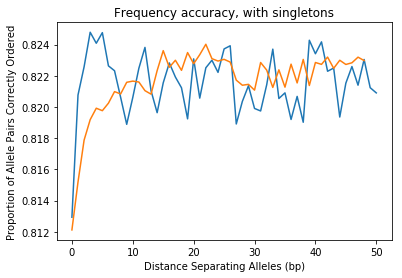

In [362]:
plt.plot(results)
plt.title("Frequency accuracy, with singletons")
plt.plot(average_predicted_values)
plt.ylabel("Proportion of Allele Pairs Correctly Ordered")
plt.xlabel("Distance Separating Alleles (bp)")

Text(0.5,0,'Distance Separating Alleles (bp)')

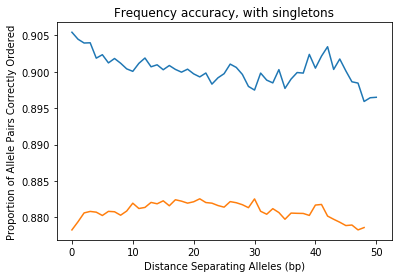

In [163]:
plt.plot(results)
plt.title("Frequency accuracy, with singletons")
plt.plot(average_predicted_values)
plt.ylabel("Proportion of Allele Pairs Correctly Ordered")
plt.xlabel("Distance Separating Alleles (bp)")

Text(0.5,0,'Distance Separating Alleles (bp)')

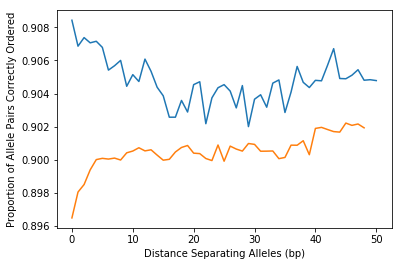

In [142]:
plt.plot(results)

plt.plot(average_predicted_values)
plt.ylabel("Proportion of Allele Pairs Correctly Ordered")
plt.xlabel("Distance Separating Alleles (bp)")

ValueError: x and y must have same first dimension, but have shapes (50,) and (51,)

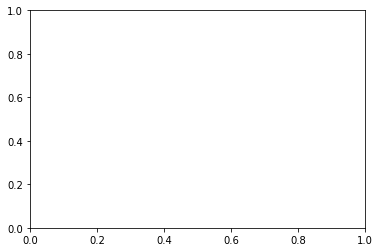

In [40]:
plt.plot(range(0,100000, 2000), results)
plt.xlabel("Distance Separating Alleles (bp)")

# Now with and without error

In [84]:
agree_overall_distances = list()
disagree_overall_distances = list()
baseline_overall_distances = list()

agree_overall_distances_error = list()
disagree_overall_distances_error = list()
baseline_overall_distances_error = list()

agree_overall_freq_diff = list()
disagree_overall_freq_diff = list()
baseline_overall_freq_diff = list()

agree_overall_freq_diff_error = list()
disagree_overall_freq_diff_error = list()
baseline_overall_freq_diff_error = list()

analytical_prediction_bins = defaultdict(list)
analytical_prediction_bins_error = defaultdict(list)

In [88]:
for i in tqdm(range(0,200,1)):
    simulation = msprime.simulate(sample_size=50, Ne=10000, length=100000, recombination_rate=2e-8, mutation_rate=2e-8)
    sample_data=generate_samples(simulation,"samples_files",0,True)
    sample_data_error=generate_samples_genotype(simulation,"error_samples_files")
    #sample_data_error=generate_samples(simulation,"samples_files",0.1,False)

    num_mutations = len(sample_data.sites_genotypes[:])

    variant_ages = [(mutation.id,simulation.node(mutation.node).time) for mutation in list(simulation.mutations())]

    variant_frequencies = [len(geno[geno==1])/len(geno) for geno in sample_data.sites_genotypes[:]]
    variant_frequencies_error = [len(geno[geno==1])/len(geno) for geno in sample_data_error.sites_genotypes[:]]
    variant_nums = [len(geno[geno==1]) for geno in sample_data.sites_genotypes[:]]
    variant_nums_error = [len(geno[geno==1]) for geno in sample_data_error.sites_genotypes[:]]
    mutation_positions=[mutation.position for mutation in list(simulation.mutations())]
    try:
        assert(len(sample_data.sites_genotypes[:]) == len(sample_data_error.sites_genotypes[:]) == len(variant_ages) == len(variant_frequencies)
            == len(variant_frequencies_error) == len(mutation_positions))
    except AssertionError as error:
        print(len(sample_data.sites_genotypes[:]),len(sample_data_error.sites_genotypes[:]), len(variant_ages), len(variant_frequencies), len(variant_frequencies_error), len(mutation_positions))

    for combo in list(itertools.combinations(range(0,num_mutations),2)):
        age1 = variant_ages[combo[0]]
        age2 = variant_ages[combo[1]]

        freq1 = variant_frequencies[combo[0]]
        freq2 = variant_frequencies[combo[1]]

        try:
            variant_frequencies_error[combo[0]]
        except IndexError:
            print(combo[0],len(variant_frequencies_error))

        freq1_error = variant_frequencies_error[combo[0]]
        freq2_error = variant_frequencies_error[combo[1]]

        freq_diff = abs(freq1 - freq2)
        freq_diff_error = abs(freq1_error - freq2_error)
        distance = abs(mutation_positions[combo[0]] - mutation_positions[combo[1]])
        
        if (age1[1] != age2[1]):
            if (freq1 != freq2):
            #if (freq1 != freq2) and (age1[1] != age2[1]) and (freq1 != 1/50) and (freq2 != 1/50):
            #if (freq1 != freq2) and (freq1 != 1/50) and (freq2 != 1/50):
                if ((age1[1] < age2[1]) == (freq1 < freq2)):
                    agree_overall_freq_diff.append(freq_diff)
                    agree_overall_distances.append(distance)

                else:
                    disagree_overall_freq_diff.append(freq_diff)
                    disagree_overall_distances.append(distance)

                baseline_overall_distances.append(distance)
                baseline_overall_freq_diff.append(freq_diff)
                

                if variant_nums[combo[0]] < variant_nums[combo[1]]:

                    analytical_prediction_bins[int(distance/2000)].append(analytical_result_51[variant_nums[combo[0]],50-variant_nums[combo[0]],variant_nums[combo[1]],50-variant_nums[combo[1]]])
                else: 
                    analytical_prediction_bins[int(distance/2000)].append(analytical_result_51[variant_nums[combo[1]],50-variant_nums[combo[1]],variant_nums[combo[0]],50-variant_nums[combo[0]]])


            else:
    #         #elif (freq1 != 1/50) and (freq2 != 1/50):
                if (random.choice([True, False])):
                    agree_overall_freq_diff.append(freq_diff)
                    agree_overall_distances.append(distance)
                   
                else:
                    disagree_overall_freq_diff.append(freq_diff)
                    disagree_overall_distances.append(distance)
                    
                baseline_overall_distances.append(distance)
                baseline_overall_freq_diff.append(freq_diff)
                
                analytical_prediction_bins[int(distance/2000)].append(analytical_result_51[variant_nums[combo[0]],50-variant_nums[combo[0]],variant_nums[combo[1]],50-variant_nums[combo[1]]])


            if (freq1_error != freq2_error):
            #if (freq1_error != freq2_error) and (age1[1] != age2[1]) and (freq1_error != 1/50) and (freq2_error != 1/50):
            #if (freq1_error != freq2_error) and (freq1_error != 1/50) and (freq2_error != 1/50):
                if ((age1[1] < age2[1]) == (freq1_error < freq2_error)):
                    agree_overall_freq_diff_error.append(freq_diff_error)
                    agree_overall_distances_error.append(distance)

                else:
                    disagree_overall_freq_diff_error.append(freq_diff_error)
                    disagree_overall_distances_error.append(distance)

                baseline_overall_distances_error.append(distance)
                baseline_overall_freq_diff_error.append(freq_diff_error)
                

                if variant_nums_error[combo[0]] < variant_nums_error[combo[1]]:

                    analytical_prediction_bins_error[int(distance/2000)].append(analytical_result_51[variant_nums_error[combo[0]],50-variant_nums_error[combo[0]],variant_nums_error[combo[1]],50-variant_nums_error[combo[1]]])
                else: 
                    analytical_prediction_bins_error[int(distance/2000)].append(analytical_result_51[variant_nums_error[combo[1]],50-variant_nums_error[combo[1]],variant_nums_error[combo[0]],50-variant_nums_error[combo[0]]])

            else:
    #         #elif (freq1_error != 1/50) and (freq2_error != 1/50):
                if (random.choice([True, False])):
                    agree_overall_freq_diff_error.append(freq_diff)
                    agree_overall_distances_error.append(distance)
                    
                    
                else:
                    disagree_overall_freq_diff_error.append(freq_diff)
                    disagree_overall_distances_error.append(distance) 
                  
                    
                baseline_overall_distances_error.append(distance)
                baseline_overall_freq_diff_error.append(freq_diff_error)
                
                analytical_prediction_bins_error[int(distance/2000)].append(analytical_result_51[variant_nums_error[combo[0]],50-variant_nums_error[combo[0]],variant_nums_error[combo[1]],50-variant_nums_error[combo[1]]])

   

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

KeyboardInterrupt: 

In [512]:
average_predicted_values = list()
for i in range(1,50,1):
    average_predicted_values.append(np.mean(analytical_prediction_bins[i]))
    
average_predicted_values_error = list()
for i in range(1,50,1):
    average_predicted_values_error.append(np.nanmean(analytical_prediction_bins_error[i]))

In [513]:
bins = np.linspace(0, 100000, 51)
digitized_baseline = np.digitize(baseline_overall_distances, bins)
digitized_disagree = np.digitize(disagree_overall_distances, bins)
digitized_agree = np.digitize(agree_overall_distances, bins)

baseline_counts = np.unique(digitized_baseline, return_counts=True)
disagree_counts = np.unique(digitized_disagree, return_counts=True)
agree_counts = np.unique(digitized_agree, return_counts=True)

results = [agree_counts[1][agree_counts[0] == count[0]][0]/count[1] for count in zip(baseline_counts[0],baseline_counts[1]) if count[0] in agree_counts[0]]

digitized_baseline_error = np.digitize(baseline_overall_distances_error, bins)
digitized_disagree_error = np.digitize(disagree_overall_distances_error, bins)
digitized_agree_error = np.digitize(agree_overall_distances_error, bins)

baseline_counts_error = np.unique(digitized_baseline_error, return_counts=True)
disagree_counts_error = np.unique(digitized_disagree_error, return_counts=True)
agree_counts_error = np.unique(digitized_agree_error, return_counts=True)

results_error = [agree_counts_error[1][agree_counts_error[0] == count[0]][0]/count[1] for count in zip(baseline_counts_error[0],baseline_counts_error[1]) if count[0] in agree_counts_error[0]]


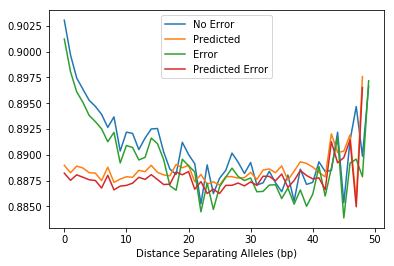

In [514]:
#With SINGLETONS, don't consider any of the same age, flip coin for same frequency
plt.plot(results,label="No Error")


plt.xlabel("Distance Separating Alleles (bp)")
plt.plot(average_predicted_values, label="Predicted")

plt.plot(results_error,label="Error")
plt.plot(average_predicted_values_error,label="Predicted Error")


plt.legend()

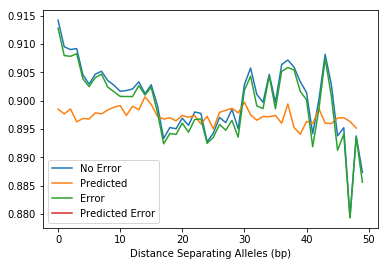

In [441]:
#With SINGLETONS, don't consider any of the same age
plt.plot(results,label="No Error")


plt.xlabel("Distance Separating Alleles (bp)")
plt.plot(average_predicted_values, label="Predicted")

plt.plot(results_error,label="Error")
plt.plot(average_predicted_values_error,label="Predicted Error")


plt.legend()

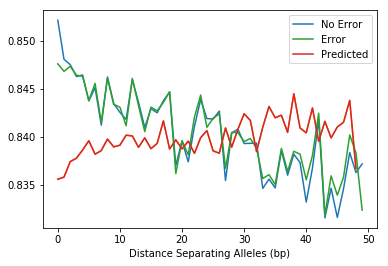

In [421]:
#WITHOUT SINGLETONS
plt.plot(results,label="No Error")


plt.xlabel("Distance Separating Alleles (bp)")
plt.plot(average_predicted_values, label="Predicted")

plt.plot(results_error,label="Error")
plt.plot(average_predicted_values_error,label="Predicted Error")


plt.legend()

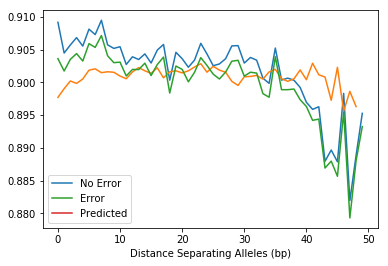

In [429]:
#WITH SINGLETONS
plt.plot(results,label="No Error")


plt.xlabel("Distance Separating Alleles (bp)")
plt.plot(average_predicted_values)

plt.plot(results_error,label="Error")
plt.plot(average_predicted_values_error,label="Predicted")

plt.legend()

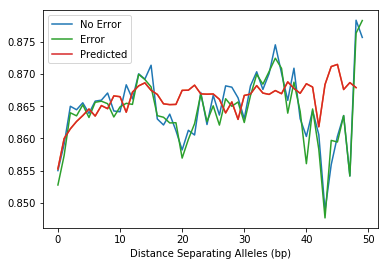

In [234]:
#Flipping a coin when age/freq are equal
plt.plot(results,label="No Error")


plt.xlabel("Distance Separating Alleles (bp)")
plt.plot(average_predicted_values)

plt.plot(results_error,label="Error")
plt.plot(average_predicted_values_error,label="Predicted")

plt.legend()

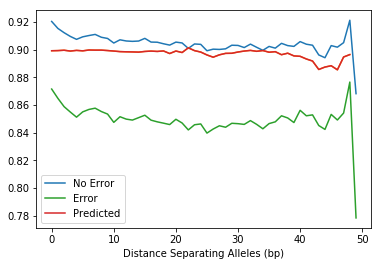

In [225]:
#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(10,5))
plt.plot(results,label="No Error")


plt.xlabel("Distance Separating Alleles (bp)")
plt.plot(average_predicted_values)

plt.plot(results_error,label="Error")
plt.plot(average_predicted_values_error,label="Predicted")

plt.legend()

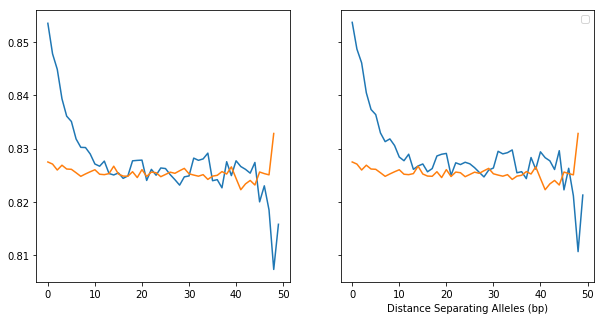

In [388]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(10,5))
ax1.plot(results)


plt.xlabel("Distance Separating Alleles (bp)")
ax1.plot(average_predicted_values)

ax2.plot(results_error)
ax2.plot(average_predicted_values_error)

plt.legend()

# Joined Samples

In [3]:
file_list_nosingletons_basedon_sample_100_2e5 = ["/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_nosingletons_basedonsample_100_2e5",
    "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree_nosingletons_basedonsample_100_2e5",
    "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_nosingletons_basedonsample_100_2e5",
                                                "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_nosingletons_basedonsample_100_2e5",
                                                "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_nosingletons_basedonsample_100_2e5",
                                                 "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_nosingletons_basedonsample_100_2e5"]

file_list_analytical = ["/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_analytical",
    "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree_analytical",
    "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_analytical",
                                                "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_analytical",
                                                "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_analytical",
                                                 "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_analytical"]

file_list_analytical_with_singletons = ["/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_analytical_withsingletons",
    "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree_analytical_withsingletons",
    "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_analytical_withsingletons",
                                                "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_analytical_withsingletons",
                                                "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_analytical_withsingletons",
                                                 "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_analytical_withsingletons"]

file_list_analytical_based_singletons = ["/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_analytical_samesingletons",
    "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree_analytical_samesingletons",
    "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_analytical_samesingletons",
                                                "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_analytical_samesingletons",
                                                "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_analytical_samesingletons",
                                                 "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_analytical_samesingletons"]


In [4]:
def read_csvs(file_list):
    agree=pd.read_csv(file_list[0],delimiter=" ",header=None,skiprows=0)
    disagree=pd.read_csv(file_list[1],delimiter=" ",header=None,skiprows=0)
    baseline=pd.read_csv(file_list[2],delimiter=" ",header=None,skiprows=0)
    agree=agree.fillna(0)
    disagree=disagree.fillna(0)
    baseline=baseline.fillna(0)
    
    agree_error=pd.read_csv(file_list[3],delimiter=" ",header=None,skiprows=0)
    disagree_error=pd.read_csv(file_list[4],delimiter=" ",header=None,skiprows=0)
    baseline_error=pd.read_csv(file_list[5],delimiter=" ",header=None,skiprows=0)
    agree_error=agree_error.fillna(0)
    disagree_error=disagree_error.fillna(0)
    baseline_error=baseline_error.fillna(0)
    return(agree,disagree,baseline,agree_error,disagree_error,baseline_error)

In [5]:
agree_nosingletons_sample_100_2e5,disagree_nosingletons_sample_100_2e5,baseline_nosingletons_sample_100_2e5,agree_error_nosingletons_sample_100_2e5,disagree_error_nosingletons_sample_100_2e5,baseline_error_nosingletons_sample_100_2e5 = read_csvs(file_list_nosingletons_basedon_sample_100_2e5)
agree_analytical,disagree_analytical,baseline_analytical,agree_error_analytical,disagree_error_analytical,baseline_error_analytical=read_csvs(file_list_analytical)
agree_analytical_singletons,disagree_analytical_singletons,baseline_analytical_singletons,agree_error_analytical_singletons,disagree_error_analytical_singletons,baseline_error_analytical_singletons=read_csvs(file_list_analytical_with_singletons)
agree_analytical_samesingletons,disagree_analytical_samesingletons,baseline_analytical_samesingletons,agree_error_analytical_samesingletons,disagree_error_analytical_samesingletons,baseline_error_analytical_samesingletons=read_csvs(file_list_analytical_based_singletons)


In [6]:
baseline_error=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline",delimiter=" ",header=None)
agree_error=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree",delimiter=" ",header=None)
disagree_error=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree",delimiter=" ",header=None)
agree_error=agree_error.fillna(0)
disagree_error=disagree_error.fillna(0)
baseline_error=baseline_error.fillna(0)
baseline=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline",delimiter=" ",header=None)
agree=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree",delimiter=" ",header=None)
disagree=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree",delimiter=" ",header=None)
agree=agree.fillna(0)
disagree=disagree.fillna(0)
baseline=baseline.fillna(0)


# agree_error_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_nosingletons_agree",delimiter=" ",header=None)
# disagree_error_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_nosingletons_disagree",delimiter=" ",header=None)
# baseline_error_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_nosingletons_baseline",delimiter=" ",header=None)
# agree_error_nosingletons=agree_error_nosingletons.fillna(0)
# disagree_error_nosingletons=disagree_error_nosingletons.fillna(0)
# baseline_error_nosingletons=baseline_error_nosingletons.fillna(0)

# agree_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_nosingletons_agree",delimiter=" ",header=None)
# disagree_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_nosingletons_disagree",delimiter=" ",header=None)
# baseline_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_nosingletons_baseline",delimiter=" ",header=None)
# agree_nosingletons=agree_nosingletons.fillna(0)
# disagree_nosingletons=disagree_nosingletons.fillna(0)
# baseline_nosingletons=baseline_nosingletons.fillna(0)

agree_error_15e4=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_15e4",delimiter=" ",header=None)
disagree_error_15e4=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_15e4",delimiter=" ",header=None)
baseline_error_15e4=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_15e4",delimiter=" ",header=None)
agree_error_15e4=agree_error_15e4.fillna(0)
disagree_error_15e4=disagree_error_15e4.fillna(0)
baseline_error_15e4=baseline_error_15e4.fillna(0)

agree_15e4=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_15e4",delimiter=" ",header=None)
disagree_15e4=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree_15e4",delimiter=" ",header=None)
baseline_15e4=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_15e4",delimiter=" ",header=None)
agree_15e4=agree_15e4.fillna(0)
disagree_15e4=disagree_15e4.fillna(0)
baseline_15e4=baseline_15e4.fillna(0)

agree_error_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_nosingletons",delimiter=" ",header=None)
disagree_error_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_nosingletons",delimiter=" ",header=None)
baseline_error_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_nosingletons",delimiter=" ",header=None)
agree_error_nosingletons=agree_error_nosingletons.fillna(0)
disagree_error_nosingletons=disagree_error_nosingletons.fillna(0)
baseline_error_nosingletons=baseline_error_nosingletons.fillna(0)

agree_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_nosingletons",delimiter=" ",header=None)
disagree_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree_nosingletons",delimiter=" ",header=None)
baseline_nosingletons=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_nosingletons",delimiter=" ",header=None)
agree_nosingletons=agree_nosingletons.fillna(0)
disagree_nosingletons=disagree_nosingletons.fillna(0)
baseline_nosingletons=baseline_nosingletons.fillna(0)

agree_error_nosingletons_1000=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_nosingletons_1000",delimiter=" ",header=None)
disagree_error_nosingletons_1000=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_nosingletons_1000",delimiter=" ",header=None)
baseline_error_nosingletons_1000=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_nosingletons_1000",delimiter=" ",header=None)
agree_error_nosingletons_1000=agree_error_nosingletons_1000.fillna(0)
disagree_error_nosingletons_1000=disagree_error_nosingletons_1000.fillna(0)
baseline_error_nosingletons_1000=baseline_error_nosingletons_1000.fillna(0)

agree_nosingletons_1000=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_nosingletons_1000",delimiter=" ",header=None)
disagree_nosingletons_1000=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree_nosingletons_1000",delimiter=" ",header=None)
baseline_nosingletons_1000=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_nosingletons_1000",delimiter=" ",header=None)
agree_nosingletons_1000=agree_nosingletons_1000.fillna(0)
disagree_nosingletons_1000=disagree_nosingletons_1000.fillna(0)
baseline_nosingletons_1000=baseline_nosingletons_1000.fillna(0)

agree_error_nosingletons_basedonsample=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_nosingletons_basedonsample_100",delimiter=" ",header=None)
disagree_error_nosingletons_basedonsample=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_nosingletons_basedonsample_100",delimiter=" ",header=None)
baseline_error_nosingletons_basedonsample=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_nosingletons_basedonsample_100",delimiter=" ",header=None)
agree_error_nosingletons_basedonsample=agree_error_nosingletons_basedonsample.fillna(0)
disagree_error_nosingletons_basedonsample=disagree_error_nosingletons_basedonsample.fillna(0)
baseline_error_nosingletons_basedonsample=baseline_error_nosingletons_basedonsample.fillna(0)

agree_nosingletons_basedonsample=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_nosingletons_basedonsample_100",delimiter=" ",header=None)
disagree_nosingletons_basedonsample=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_disagree_nosingletons_basedonsample_100",delimiter=" ",header=None)
baseline_nosingletons_basedonsample=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_nosingletons_basedonsample_100",delimiter=" ",header=None)
agree_nosingletons_basedonsample=agree_nosingletons_basedonsample.fillna(0)
disagree_nosingletons_basedonsample=disagree_nosingletons_basedonsample.fillna(0)
baseline_nosingletons_basedonsample=baseline_nosingletons_basedonsample.fillna(0)

In [7]:
def find_averages(agree_input,disagree_input,baseline_input):
    overall_results_disagree = np.zeros((1,50))
    overall_results_agree = np.zeros((1,50))
    overall_results_baseline = np.zeros((1,50))
    for index,row in enumerate(disagree_input.as_matrix()):
        if (index % 2 == 1):
            overall_results_disagree = np.add(overall_results_disagree,row)
       
    for index,row in enumerate(agree_input.as_matrix()):
        if (index % 2 == 1):
            overall_results_agree = np.add(overall_results_agree,row)

    for index,row in enumerate(baseline_input.as_matrix()):
        if (index % 2 == 1):
            overall_results_baseline = np.add(overall_results_baseline,row)
    return(overall_results_agree,overall_results_disagree,overall_results_baseline)

In [8]:
overall_results_agree, overall_results_disagree, overall_results_baseline = find_averages(agree,disagree,baseline)
overall_results_agree_error, overall_results_disagree_error, overall_results_baseline_error = find_averages(agree_error,disagree_error,baseline_error)
overall_results_agree_nosingletons, overall_results_disagree_nosingletons, overall_results_baseline_nosingletons = find_averages(agree_nosingletons,disagree_nosingletons,baseline_nosingletons)
overall_results_agree_error_nosingletons, overall_results_disagree_error_nosingletons, overall_results_baseline_error_nosingletons = find_averages(agree_error_nosingletons,disagree_error_nosingletons,baseline_error_nosingletons)
overall_results_agree_15e4, overall_results_disagree_15e4, overall_results_baseline_15e4 = find_averages(agree_15e4,disagree_15e4,baseline_15e4)
overall_results_agree_error_15e4, overall_results_disagree_error_15e4, overall_results_baseline_error_15e4 = find_averages(agree_error_15e4,disagree_error_15e4,baseline_error_15e4)
overall_results_agree_nosingletons_1000, overall_results_disagree_nosingletons_1000, overall_results_baseline_nosingletons_1000 = find_averages(agree_nosingletons_1000,disagree_nosingletons_1000,baseline_nosingletons_1000)
overall_results_agree_error_nosingletons_1000, overall_results_disagree_error_nosingletons_1000, overall_results_baseline_error_nosingletons_1000 = find_averages(agree_error_nosingletons_1000,disagree_error_nosingletons_1000,baseline_error_nosingletons_1000)
overall_results_agree_nosingletons_basedonsample, overall_results_disagree_nosingletons_basedonsample, overall_results_baseline_nosingletons_basedonsample = find_averages(agree_nosingletons_basedonsample,disagree_nosingletons_basedonsample,baseline_nosingletons_basedonsample)
overall_results_agree_error_nosingletons_basedonsample, overall_results_disagree_error_nosingletons_basedonsample, overall_results_baseline_error_nosingletons_basedonsample = find_averages(agree_error_nosingletons_basedonsample,disagree_error_nosingletons_basedonsample,baseline_error_nosingletons_basedonsample)
overall_results_agree_nosingletons_basedonsample_2e5, overall_results_disagree_nosingletons_basedonsample_2e5, overall_results_baseline_nosingletons_basedonsample_2e5 = find_averages(agree_nosingletons_sample_100_2e5,disagree_nosingletons_sample_100_2e5,baseline_nosingletons_sample_100_2e5)
overall_results_agree_error_nosingletons_basedonsample_2e5, overall_results_disagree_error_nosingletons_basedonsample_2e5, overall_results_baseline_error_nosingletons_basedonsample_2e5 = find_averages(agree_error_nosingletons_sample_100_2e5,disagree_error_nosingletons_sample_100_2e5,baseline_error_nosingletons_sample_100_2e5)
overall_results_agree_analytical, overall_results_disagree_analytical, overall_results_baseline_analytical = find_averages(agree_analytical,
                                                                                                                           disagree_analytical,
                                                                                                                           baseline_analytical)
overall_results_agree_error_analytical, overall_results_disagree_error_analytical, overall_results_baseline_error_analytical = find_averages(agree_error_analytical,
                                                                                                                                             disagree_error_analytical,
                                                                                                                                             baseline_error_analytical)
overall_results_agree_analytical_withsingletons, overall_results_disagree_analytical_withsingletons, overall_results_baseline_analytical_withsingletons = find_averages(agree_analytical_singletons, 
                                                                                                                                                                        disagree_analytical_singletons,
                                                                                                                                                                        baseline_analytical_singletons)
overall_results_agree_error_analytical_withsingletons, overall_results_disagree_error_analytical_withsingletons, overall_results_baseline_error_analytical_withsingletons = find_averages(agree_error_analytical_singletons,
                                                                                                                                                                                          disagree_error_analytical_singletons,
                                                                                                                                                                                          baseline_error_analytical_singletons)
overall_results_agree_analytical_removesamesingletons, overall_results_disagree_analytical_removesamesingletons, overall_results_baseline_analytical_removesamesingletons = find_averages(agree_analytical_samesingletons,
                                                                                                                                                                                          disagree_analytical_samesingletons,
                                                                                                                                                                                          baseline_analytical_samesingletons)
overall_results_agree_error_analytical_removesamesingletons, overall_results_disagree_error_analytical_removesamesingletons, overall_results_baseline_error_analytical_removesamesingletons = find_averages(agree_error_analytical_samesingletons,
                                                                                                                                                                                                            disagree_error_analytical_samesingletons,
                                                                                                                                                                                                            baseline_error_analytical_samesingletons)



In [9]:
results = [overall_results_agree[key]/value for key,value in enumerate(overall_results_baseline)]
results_error = [overall_results_agree_error[key]/value for key,value in enumerate(overall_results_baseline_error)]
results_nosingletons = [overall_results_agree_nosingletons[key]/value for key,value in enumerate(overall_results_baseline_nosingletons)]
results_error_nosingletons = [overall_results_agree_error_nosingletons[key]/value for key,value in enumerate(overall_results_baseline_error_nosingletons)]
results_15e4 = [overall_results_agree_15e4[key]/value for key,value in enumerate(overall_results_baseline_15e4)]
results_error_15e4 = [overall_results_agree_error_15e4[key]/value for key,value in enumerate(overall_results_baseline_error_15e4)]
results_nosingletons_1000 = [overall_results_agree_nosingletons_1000[key]/value for key,value in enumerate(overall_results_baseline_nosingletons_1000)]
results_error_nosingletons_1000 = [overall_results_agree_error_nosingletons_1000[key]/value for key,value in enumerate(overall_results_baseline_error_nosingletons_1000)]
results_nosingletons_basedonsample = [overall_results_agree_nosingletons_basedonsample[key]/value for key,value in enumerate(overall_results_baseline_nosingletons_basedonsample)]
results_error_nosingletons_basedonsample = [overall_results_agree_error_nosingletons_basedonsample[key]/value for key,value in enumerate(overall_results_baseline_error_nosingletons_basedonsample)]
results_nosingletons_basedonsample_2e5 = [overall_results_agree_nosingletons_basedonsample_2e5[key]/value for key,value in enumerate(overall_results_baseline_nosingletons_basedonsample_2e5)]
results_error_nosingletons_basedonsample_2e5 = [overall_results_agree_error_nosingletons_basedonsample_2e5[key]/value for key,value in enumerate(overall_results_baseline_error_nosingletons_basedonsample_2e5)]
results_analytical = [overall_results_agree_analytical[key]/value for key,value in enumerate(overall_results_baseline_analytical)]
results_error_analytical = [overall_results_agree_error_analytical[key]/value for key,value in enumerate(overall_results_baseline_error_analytical)]
results_analytical_withsingletons = [overall_results_agree_analytical_withsingletons[key]/value for key,value in enumerate(overall_results_baseline_analytical_withsingletons)]
results_error_analytical_withsingletons = [overall_results_agree_error_analytical_withsingletons[key]/value for key,value in enumerate(overall_results_baseline_error_analytical_withsingletons)]
results_analytical_removesamesingletons = [overall_results_agree_analytical_removesamesingletons[key]/value for key,value in enumerate(overall_results_baseline_analytical_removesamesingletons)]
results_error_analytical_removesamesingletons = [overall_results_agree_error_analytical_removesamesingletons[key]/value for key,value in enumerate(overall_results_baseline_error_analytical_removesamesingletons)]


In [10]:
analytical_files = ["/home/wilderwohns/tsinfer_paper/data/simulation_results_new/average_predicted_valuesanalytical","/home/wilderwohns/tsinfer_paper/data/simulation_results_new/average_predicted_values_erroranalytical"]
analytical_with_singletons_files = ["/home/wilderwohns/tsinfer_paper/data/simulation_results_new/average_predicted_valuesanalytical_withsingletons","/home/wilderwohns/tsinfer_paper/data/simulation_results_new/average_predicted_values_erroranalytical_withsingletons"]
analytical_with_same_singletons_files = ["/home/wilderwohns/tsinfer_paper/data/simulation_results_new/average_predicted_valuesanalytical_samesingletons","/home/wilderwohns/tsinfer_paper/data/simulation_results_new/average_predicted_values_erroranalytical_samesingletons"]

def get_analytical_results(files):
    analytical_predicted_values = pd.read_csv(files[0],header=None)
    average_predicted_values = defaultdict(list)
    for i,value in analytical_predicted_values.iterrows():
        average_predicted_values[0,i % 50].append(value)

    average_predicted_bins = list()
    for i in range(1,50,1):
        average_predicted_bins.append(np.nanmean(average_predicted_values[0,i]))
    
    error_analytical_predicted_values = pd.read_csv(files[1],header=None)
    error_average_predicted_values = defaultdict(list)
    for i,value in error_analytical_predicted_values.iterrows():
        error_average_predicted_values[0,i % 50].append(value)


    error_average_predicted_bins = list()
    for i in range(1,50,1):
        error_average_predicted_bins.append(np.nanmean(error_average_predicted_values[0,i]))
    return(average_predicted_bins,error_average_predicted_bins)

In [11]:
predicted_analytical,predicted_analytical_error=get_analytical_results(analytical_files)
predicted_analytical_wsingletons,predicted_analytical_error_wsingletons=get_analytical_results(analytical_with_singletons_files)
predicted_analytical_wsamesingletons,predicted_analytical_error_wsamesingletons=get_analytical_results(analytical_with_same_singletons_files)

In [12]:
from scipy import stats
print(stats.ttest_rel(results[0],results_error[0]))
print(stats.ttest_rel(results_nosingletons[0],results_error_nosingletons[0]))
print(stats.ttest_rel(results_nosingletons_1000[0],results_error_nosingletons_1000[0]))
print(stats.ttest_rel(results_nosingletons_basedonsample[0],results_error_nosingletons_basedonsample[0]))

Ttest_relResult(statistic=84.81919328874119, pvalue=7.896038926365283e-55)
Ttest_relResult(statistic=-63.69931301706753, pvalue=8.641892567449354e-49)
Ttest_relResult(statistic=-137.88709520833268, pvalue=3.989542315916264e-65)
Ttest_relResult(statistic=34.65841293437057, pvalue=3.9511226956741824e-36)


Text(0.5,0.98,'Accuracy of Allele Frequency reflecting Pairwise Time Order')

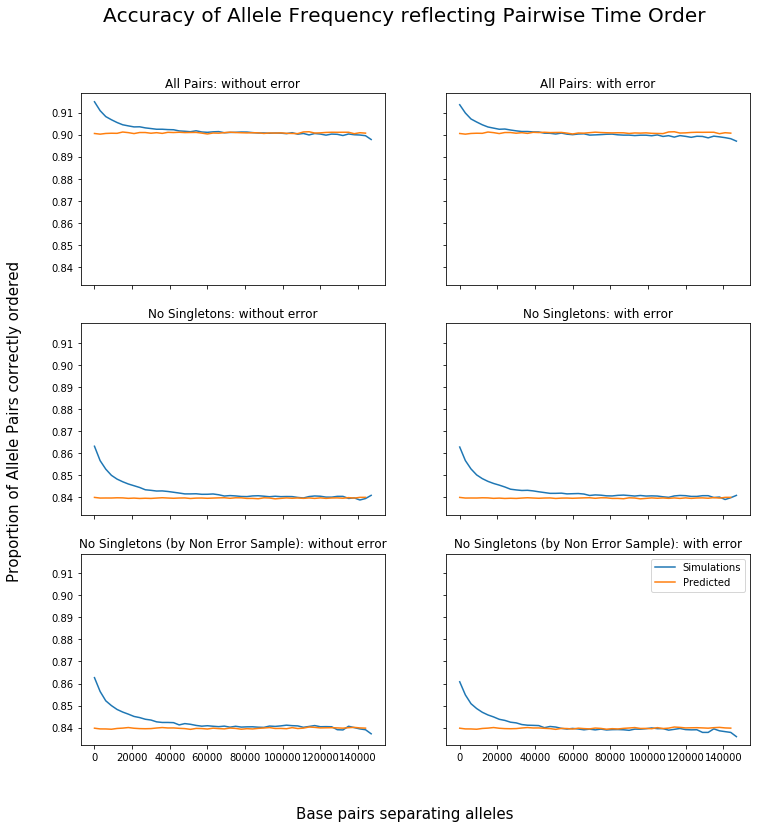

In [19]:
f, axes = plt.subplots(3, 2, sharey=True,sharex=True,figsize=(12,12))
f.text(0.5, 0.04, 'Base pairs separating alleles', ha='center',fontsize=15)
f.text(0.04, 0.5, 'Proportion of Allele Pairs correctly ordered', va='center', rotation='vertical',fontsize=15)

simulations,=axes[0,0].plot(range(0,150000, 3000),results_analytical_withsingletons[0],label="Simulations")
predicted,=axes[0,0].plot(range(0,147000, 3000),predicted_analytical_wsingletons,label="Predicted")
axes[0,1].plot(range(0,150000, 3000),results_error_analytical_withsingletons[0])
axes[0,1].plot(range(0,147000, 3000),predicted_analytical_wsingletons)
axes[0,0].set_title("All Pairs: without error")
axes[0,1].set_title("All Pairs: with error")

axes[1,0].plot(range(0,150000, 3000),results_analytical[0])
axes[1,0].plot(range(0,147000, 3000),predicted_analytical)
axes[1,1].plot(range(0,150000, 3000),results_error_analytical[0])
axes[1,1].plot(range(0,147000, 3000),predicted_analytical_error)
axes[1,0].set_title("No Singletons: without error")
axes[1,1].set_title("No Singletons: with error")


axes[2,0].plot(range(0,150000, 3000),results_analytical_removesamesingletons[0])
axes[2,0].plot(range(0,147000, 3000),predicted_analytical_wsamesingletons)
axes[2,1].plot(range(0,150000, 3000),results_error_analytical_removesamesingletons[0])
axes[2,1].plot(range(0,147000, 3000),predicted_analytical_error_wsamesingletons)
axes[2,0].set_title("No Singletons (by Non Error Sample): without error")
axes[2,1].set_title("No Singletons (by Non Error Sample): with error")

plt.legend([simulations, predicted],["Simulations", "Predicted"])
#plt.xlabel("Base pairs separating alleles")
#plt.ylabel("Proportion of Allele Pairs correctly ordered")
plt.suptitle("Accuracy of Allele Frequency reflecting Pairwise Time Order",fontsize=20)


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(10,5))
ax1.plot(range(0,150000, 3000),results_analytical[0])
#ax1.plot(results_analytical[0])
ax1.plot(range(0,147000, 3000),average_predicted_bins)
ax2.plot(range(0,150000, 3000),results_error_analytical[0])
ax2.plot(range(0,147000, 3000),error_average_predicted_bins)
ax1.set_xlabel("Base pairs separating alleles")
ax2.set_xlabel("Base pairs separating alleles")
ax1.set_ylabel("Proportion of allele pairs correctly ordered")
#plt.xlabel("Base pairs separating alleles")
#plt.ylabel("Proportion of Allele Pairs correctly ordered")
#plt.suptitle()
ax1.set_title("No error model")
ax2.set_title("Empirically Determined Error Model")
plt.suptitle("No Singletons",fontsize=20)
plt.savefig("frequency_ordering_mutation_pairs")

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(10,5))
ax1.plot(range(0,150000, 3000),results_analytical_withsingletons[0])
ax1.plot(range(0,147000, 3000),predicted_analytical_wsingletons)
ax2.plot(range(0,150000, 3000),results_error_analytical_withsingletons[0])
ax2.plot(range(0,147000, 3000),predicted_analytical_error_wsingletons)
ax1.set_xlabel("Base pairs separating alleles")
ax2.set_xlabel("Base pairs separating alleles")
ax1.set_ylabel("Proportion of allele pairs correctly ordered")
#plt.xlabel("Base pairs separating alleles")
#plt.ylabel("Proportion of Allele Pairs correctly ordered")
#plt.suptitle()
ax1.set_title("No error model")
ax2.set_title("Empirically Determined Error Model")
plt.suptitle("With Singletons",fontsize=20)
plt.savefig("frequency_ordering_mutation_pairs")

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(10,5))
ax1.plot(range(0,150000, 3000),results_analytical_removesamesingletons[0])
ax1.plot(range(0,147000, 3000),predicted_analytical_wsamesingletons)
ax2.plot(range(0,150000, 3000),results_error_analytical_removesamesingletons[0])
ax2.plot(range(0,147000, 3000),predicted_analytical_error_wsamesingletons)
ax1.set_xlabel("Base pairs separating alleles")
ax2.set_xlabel("Base pairs separating alleles")
ax1.set_ylabel("Proportion of allele pairs correctly ordered")
#plt.xlabel("Base pairs separating alleles")
#plt.ylabel("Proportion of Allele Pairs correctly ordered")
#plt.suptitle()
ax1.set_title("No error model")
ax2.set_title("Empirically Determined Error Model")
plt.suptitle("No Singletons (based on no error model)",fontsize=20)
plt.savefig("frequency_ordering_mutation_pairs")

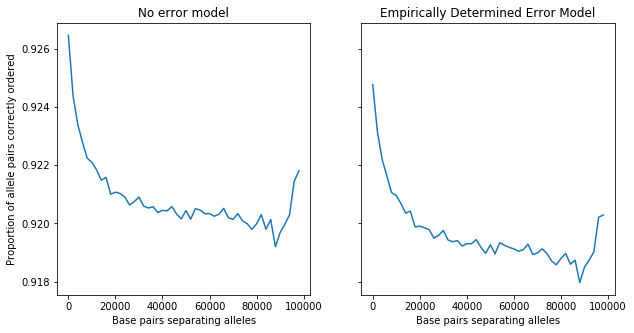

In [256]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(10,5))
ax1.plot(range(0,100000, 2000),results[0])

ax2.plot(range(0,100000, 2000),results_error[0])

ax1.set_xlabel("Base pairs separating alleles")
ax2.set_xlabel("Base pairs separating alleles")
ax1.set_ylabel("Proportion of allele pairs correctly ordered")
#plt.xlabel("Base pairs separating alleles")
#plt.ylabel("Proportion of Allele Pairs correctly ordered")
#plt.suptitle()
ax1.set_title("No error model")
ax2.set_title("Empirically Determined Error Model")
plt.savefig("frequency_ordering_mutation_pairs")

Text(0.5,1,'with error')

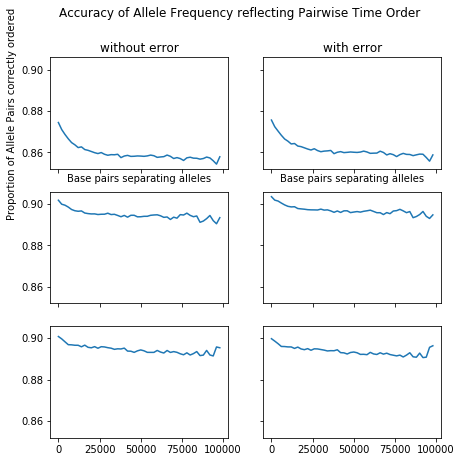

In [337]:
f, axes = plt.subplots(3, 2, sharey=True,sharex=True,figsize=(7,7))
axes[0,0].plot(range(0,100000, 2000),results_nosingletons[0])
axes[0,1].plot(range(0,100000, 2000),results_error_nosingletons[0])
axes[1,0].plot(range(0,100000, 2000),results_nosingletons_1000[0])
axes[1,1].plot(range(0,100000, 2000),results_error_nosingletons_1000[0])
axes[2,0].plot(range(0,100000, 2000),results_nosingletons_basedonsample[0])
axes[2,1].plot(range(0,100000, 2000),results_error_nosingletons_basedonsample[0])

axes[0,0].set_xlabel("Base pairs separating alleles")
axes[0,1].set_xlabel("Base pairs separating alleles")
axes[0,0].set_ylabel("Proportion of Allele Pairs correctly ordered")
#plt.xlabel("Base pairs separating alleles")
#plt.ylabel("Proportion of Allele Pairs correctly ordered")
plt.suptitle("Accuracy of Allele Frequency reflecting Pairwise Time Order")
axes[0,0].set_title("without error")
axes[0,1].set_title("with error")

Text(0.5,1,'with error')

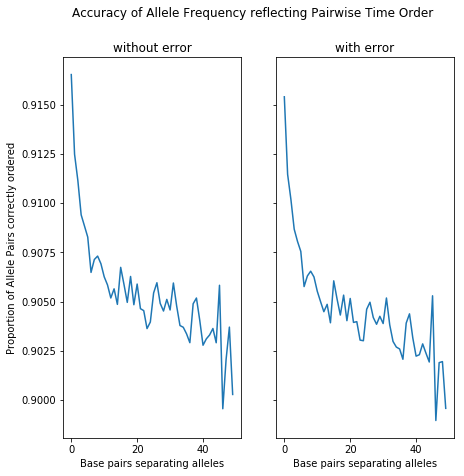

In [338]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(7,7))
ax1.plot(results_15e4[0])

ax2.plot(results_error_15e4[0])

ax1.set_xlabel("Base pairs separating alleles")
ax2.set_xlabel("Base pairs separating alleles")
ax1.set_ylabel("Proportion of Allele Pairs correctly ordered")
#plt.xlabel("Base pairs separating alleles")
#plt.ylabel("Proportion of Allele Pairs correctly ordered")
plt.suptitle("Accuracy of Allele Frequency reflecting Pairwise Time Order")
ax1.set_title("without error")
ax2.set_title("with error")

Text(0.5,1,'with error')

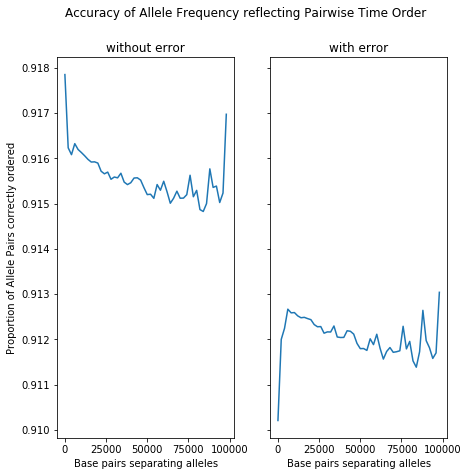

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(7,7))
ax1.plot(range(0,100000, 2000),results[0])
ax2.plot(range(0,100000, 2000),results_error[0])
ax1.set_xlabel("Base pairs separating alleles")
ax2.set_xlabel("Base pairs separating alleles")
ax1.set_ylabel("Proportion of Allele Pairs correctly ordered")
#plt.xlabel("Base pairs separating alleles")
#plt.ylabel("Proportion of Allele Pairs correctly ordered")
plt.suptitle("Accuracy of Allele Frequency reflecting Pairwise Time Order")
ax1.set_title("without error")
ax2.set_title("with error")

# Joined Samples with Analytical Predictions

Strategy: for each pair in the simluation, record the analytically predicted value and the bin it should be in. 


# Markov Chain

In [3]:
# The statespace
states = [(2,2,2,2),(1,2,2,2),(2,1,2,2),(2,2,1,2),(2,2,2,1),(2,1,2,1)]

# Possible sequences of events
transitionName = [["SS","SR","SI"],["RS","RR","RI"],["IS","IR","II"]]



In [4]:
# Probabilities matrix (transition matrix)
for state in states:
    pick_site_i_n = comb(state[0]+state[1],2)/(comb(state[0]+state[1],2)+comb(state[2]+state[3],2))
    pick_site_j_m = comb(state[2]+state[3],2)/(comb(state[0]+state[1],2)+comb(state[2]+state[3],2))
    pick_coal_i = state[0]/(state[0]+state[1]-1)
    pick_coal_n = state[1]-1/(state[0]+state[1]-1)
    pick_coal_j = state[2]/(state[2]+state[3]-1)
    pick_coal_m = state[3]-1/(state[2]+state[3]-1)
    
    print(pick_site_i_n*pick_coal_i,pick_site_i_n*pick_coal_n,pick_site_j_m*pick_coal_j,pick_site_j_m*pick_coal_m)
    #transitionMatrix = [[0.2,0.6,0.2],[0.1,0.6,0.3],[0.2,0.7,0.1]]

0.3333333333333333 0.8333333333333334 0.3333333333333333 0.8333333333333334
0.16666666666666666 0.5 0.4444444444444444 1.1111111111111112
0.3333333333333333 0.16666666666666666 0.4444444444444444 1.1111111111111112
0.4444444444444444 1.1111111111111112 0.16666666666666666 0.5
0.4444444444444444 1.1111111111111112 0.3333333333333333 0.16666666666666666
0.5 0.25 0.5 0.25


In [21]:
def recursive_solve(state):
    
    i = state[0]
    n = state[1]
    j = state[2]
    m = state[3]

    if i == 1:
        #analytical_predictions[i,n,j,m] = 1
        return(analytical_predictions[i,n,j,m])
    elif j == 1:
        #analytical_predictions[i,n,j,m] = 0
        return(analytical_predictions[i,n,j,m])
   
    #transition probabilities
    pick_site_i_n = comb(state[0]+state[1],2)/(comb(state[0]+state[1],2)+comb(state[2]+state[3],2))
    pick_site_j_m = comb(state[2]+state[3],2)/(comb(state[0]+state[1],2)+comb(state[2]+state[3],2))
    pick_coal_i = state[0]/(state[0]+state[1]-1)
    pick_coal_n = (state[1]-1)/(state[0]+state[1]-1)
    pick_coal_j = state[2]/(state[2]+state[3]-1)
    pick_coal_m = (state[3]-1)/(state[2]+state[3]-1)
    
    qs1 = pick_site_i_n*pick_coal_i
    qs2 = pick_site_i_n*pick_coal_n
    qs3 = pick_site_j_m*pick_coal_j
    qs4 = pick_site_j_m*pick_coal_m
    
    #These are the values of P_sprime
    ps1=analytical_predictions[i-1,n,j,m]
    ps2=analytical_predictions[i,n-1,j,m]
    ps3=analytical_predictions[i,n,j-1,m]
    ps4=analytical_predictions[i,n,j,m-1]
    
    #Now multiply P_sprime * transition matrix (calculating P_sprime if necessary)
    if qs1 > 0 and math.isnan(ps1):
        ps1 = recursive_solve([i-1,n,j,m])
        analytical_predictions[i-1,n,j,m] = ps1
    term1 = qs1 * ps1
    
    if qs2 > 0 and math.isnan(ps2):
        ps2 = recursive_solve([i,n-1,j,m])
        analytical_predictions[i,n-1,j,m] = ps2
    elif qs2 == 0:
        ps2 = 0
        #analytical_predictions[i,n-1,j,m] = 0  
    term2 = qs2 * ps2 
    
    if qs3 > 0 and math.isnan(ps3):
        ps3 = recursive_solve([i,n,j-1,m])
        analytical_predictions[i,n,j-1,m] = ps3
    term3 = qs3 * ps3
       
    if qs4 > 0 and math.isnan(ps4):
        ps4 = recursive_solve([i,n,j,m-1])
        analytical_predictions[i,n,j,m-1] = ps4
    elif qs4 == 0:
        ps4 = 0
        #analytical_predictions[i,n,j,m-1] = 0
        
    term4 = qs4 * ps4
    
    return(term1+term2+term3+term4)
        

In [198]:
analytical_predictions=np.full((50,50,50,50), np.nan)
analytical_predictions[1,:,:,:] = 1
analytical_predictions[:,:,1,:] = 0
analytical_predictions[1,:,1,:] = 0.5

In [199]:
a = [range(1,50,1),range(1,50,1),range(1,50,1),range(1,50,1)]
for item in tqdm(list(itertools.product(*a))):
    
    recursive_solve([item[0],item[1],item[2],item[3]])

HBox(children=(IntProgress(value=0, max=5764801), HTML(value='')))

In [200]:
analytical_predictions[30,19,30,10]

0.5928127419472178

In [201]:
analytical_result_51[30,19,30,10]

0.5928127419472178

In [202]:
analytical_predictions_50_new[30,19,30,10]

0.5928127419472178

In [32]:
naught_2_times = list()

In [47]:

for i in tqdm(range(0,1000,1)):
    simulation = msprime.simulate(sample_size=20, Ne=10000, length=100000, recombination_rate=2e-8, mutation_rate=2e-8)
    for variant in simulation.variants():
        allele_freq = len(variant.genotypes[variant.genotypes == 1])/len(variant.genotypes)
        if allele_freq == 0.2:
            naught_2_times.append(simulation.node(variant.site.mutations[0].node).time)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [34]:
naught_8_times = list()

In [48]:

for i in tqdm(range(0,1000,1)):
    simulation = msprime.simulate(sample_size=20, Ne=10000, length=100000, recombination_rate=2e-8, mutation_rate=2e-8)
    for variant in simulation.variants():
        allele_freq = len(variant.genotypes[variant.genotypes == 1])/len(variant.genotypes)
        if allele_freq == 0.8:
            naught_8_times.append(simulation.node(variant.site.mutations[0].node).time)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [49]:
accuracy_list = list()
for times in zip(naught_2_times,naught_8_times):
    
    if times[0] > times[1]:
        accuracy_list.append(1)
    elif times[0] < times[1]:
        accuracy_list.append(0)

In [50]:
np.unique(accuracy_list,return_counts=True)

(array([0, 1]), array([14067,   983]))

In [53]:
1-(983/14067)

0.9301201393331912

0.36313629244119056

In [20]:
analytical_result_51 = np.reshape(np.loadtxt("/home/wilderwohns/analytical_ordering/analytical_predictions(51, 51, 51, 51).txt"),(51,51,51,51))

Now try for sample size 20, is the average result the same as it was with sample size 50? Note, this uses come code from below where we calculate the average with q_bar and theta

In [53]:
analytical_predictions=np.full((70,70,70,70), np.nan)
analytical_predictions[1,:,:,:] = 1
analytical_predictions[:,:,1,:] = 0
analytical_predictions[1,:,1,:] = 0.5

In [54]:
a = [range(1,70,1),range(1,70,1),range(1,70,1),range(1,70)]

In [ ]:
for item in tqdm(list(itertools.product(*a))):
    recursive_solve([item[0],item[1],item[2],item[3]])

HBox(children=(IntProgress(value=0, max=22667121), HTML(value='')))

In [1]:
i_j_70 = np.zeros((70,70))
for i in range(1,70,1):
    
    for j in range(1,70,1):
        i_j_70[i,j] = np.nanmean(analytical_predictions[i,:,j,:])

NameError: name 'np' is not defined

In [ ]:
total_val = 0
for i in range(1,70):
    for j in range(1,70):
        total_val += 1/(i*j)

In [ ]:
theta = 1/total_val

In [ ]:
q_bar = 0
for i in range(1,70):
    for j in range(1,70):
        if i <= j:
            q_bar += theta/((i*j)) * i_j_70[i,j]
        else:
            q_bar += theta/((i*j)) * (1-i_j_70[i,j])

In [52]:
#result for sample size 20
q_bar

0.8031507742672552

# Checking accuracy of Analytical result

In [ ]:
"""
2000 Simulations without error, calculate freq does not equal age
"""
for i in tqdm(range(0,2000,1)):
    distance=0
    simulation = msprime.simulate(sample_size=20, Ne=10000, length=100000, recombination_rate=2e-8, mutation_rate=2e-8)
    sample_data=generate_samples(simulation,"test",0,True)
    

    num_mutations = len(sample_data.sites_genotypes[:])

    variant_ages = [(mutation.id,simulation.node(mutation.node).time) for mutation in list(simulation.mutations())]
    variant_frequencies = [len(geno[geno==1])/len(geno) for geno in sample_data.sites_genotypes[:]]
    variant_nums = [len(geno[geno==1]) for geno in sample_data.sites_genotypes[:]]
    mutation_positions=[mutation.position for mutation in list(simulation.mutations())]


    for combo in list(itertools.combinations(range(0,num_mutations),2)):
        age1 = variant_ages[combo[0]]
        age2 = variant_ages[combo[1]]
        freq1 = variant_frequencies[combo[0]]
        freq2 = variant_frequencies[combo[1]]
        freq_diff = abs(freq1 - freq2)
        
        if (freq1 != freq2) and (freq1 != 1/20) and (freq2 != 1/20):
            distance = abs(mutation_positions[combo[0]] - mutation_positions[combo[1]])
            baseline_overall_distances.append(distance)
            baseline_overall_freq_diff.append(freq_diff)
            if ((age1[1] <= age2[1]) == (freq1 <= freq2)):
                
                agree_overall_freq_diff.append(freq_diff)
                agree_overall_distances.append(distance)
                
            else:
                disagree_overall_freq_diff.append(freq_diff)
                disagree_overall_distances.append(distance)
                
            if variant_nums[combo[0]] < variant_nums[combo[1]]:
               
                analytical_prediction_bins[int(distance/2000)].append(analytical_predictions[variant_nums[combo[0]],20-variant_nums[combo[0]],variant_nums[combo[1]],20-variant_nums[combo[1]]])
            else: 
                analytical_prediction_bins[int(distance/2000)].append(analytical_predictions[variant_nums[combo[1]],20-variant_nums[combo[1]],variant_nums[combo[0]],20-variant_nums[combo[0]]])
                
                
                
            freq_not_equal.append((distance,freq_diff))
        else:
            freq_equal.append((distance,freq_diff))
        distance_freq.append((distance,freq_diff))
       


# Freq difference


In [23]:
freq_diff_files = ["/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_agree_freq_diff_freq_diff",
                  "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_freq_diff_freq_diff",
                  "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/simulation_results_baseline_freq_diff_freq_diff",
                  "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_agree_freq_diff_freq_diff",
                  "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_disagree_freq_diff_freq_diff",
                  "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/error_simulation_results_baseline_freq_diff_freq_diff"]

In [24]:
freq_diff_agree,freq_diff_disagree,freq_diff_baseline,error_freq_diff_agree,error_freq_diff_disagree,error_freq_diff_baseline=read_csvs_freq_diff(freq_diff_files)

In [25]:
def read_csvs_freq_diff(file_list):
    agree=pd.read_csv(file_list[0],delimiter=" ",header=None,skiprows=0,names=range(1,20,1))
    disagree=pd.read_csv(file_list[1],delimiter=" ",header=None,skiprows=0,names=range(1,20,1))
    baseline=pd.read_csv(file_list[2],delimiter=" ",header=None,skiprows=0,names=range(1,20,1))
    agree=agree.fillna(0)
    disagree=disagree.fillna(0)
    baseline=baseline.fillna(0)
    
    agree_error=pd.read_csv(file_list[3],delimiter=" ",header=None,skiprows=0,names=range(1,20,1))
    disagree_error=pd.read_csv(file_list[4],delimiter=" ",header=None,skiprows=0,names=range(1,20,1))
    baseline_error=pd.read_csv(file_list[5],delimiter=" ",header=None,skiprows=0,names=range(1,20,1))
    agree_error=agree_error.fillna(0)
    disagree_error=disagree_error.fillna(0)
    baseline_error=baseline_error.fillna(0)
    return(agree,disagree,baseline,agree_error,disagree_error,baseline_error)

In [ ]:
def find_averages_freq_diff(agree_input,disagree_input,baseline_input):
    overall_results_disagree = np.zeros((1,19))
    overall_results_agree = np.zeros((1,19))
    overall_results_baseline = np.zeros((1,19))
    for index,row in enumerate(disagree_input.as_matrix()):
        if (index % 2 == 1):
            overall_results_disagree = np.add(overall_results_disagree,row)
       
    for index,row in enumerate(agree_input.as_matrix()):
        if (index % 2 == 1):
            overall_results_agree = np.add(overall_results_agree,row)

    for index,row in enumerate(baseline_input.as_matrix()):
        if (index % 2 == 1):
            overall_results_baseline = np.add(overall_results_baseline,row)
    return(overall_results_agree,overall_results_disagree,overall_results_baseline)

In [430]:
overall_results_agree, overall_results_disagree, overall_results_baseline = find_averages_freq_diff(freq_diff_agree,freq_diff_disagree,freq_diff_baseline)
overall_results_agree_error, overall_results_disagree_error, overall_results_baseline_error = find_averages_freq_diff(error_freq_diff_agree,error_freq_diff_disagree,error_freq_diff_baseline)


results = [overall_results_agree[key]/value for key,value in enumerate(overall_results_baseline)]
results_error = [overall_results_agree_error[key]/value for key,value in enumerate(overall_results_baseline_error)]


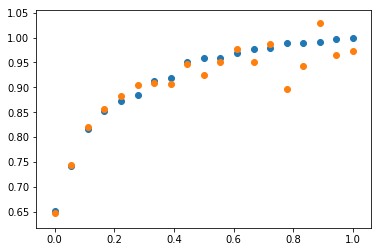

In [443]:
plt.scatter(np.linspace(0,1,19),results)
plt.scatter(np.linspace(0,1,19),results_error)

In [ ]:
freq_diff_predicted = "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/average_predicted_valuesfreq_diff"
freq_diff_predicted_error = "/home/wilderwohns/tsinfer_paper/data/simulation_results_new/average_predicted_values_errorfreq_diff"

def get_analytical_results(files):
    analytical_predicted_values = pd.read_csv(files[0],header=None)
    average_predicted_values = defaultdict(list)
    for i,value in analytical_predicted_values.iterrows():
        average_predicted_values[0,i % 50].append(value)

    average_predicted_bins = list()
    for i in range(1,50,1):
        average_predicted_bins.append(np.nanmean(average_predicted_values[0,i]))
    
    error_analytical_predicted_values = pd.read_csv(files[1],header=None)
    error_average_predicted_values = defaultdict(list)
    for i,value in error_analytical_predicted_values.iterrows():
        error_average_predicted_values[0,i % 50].append(value)


    error_average_predicted_bins = list()
    for i in range(1,50,1):
        error_average_predicted_bins.append(np.nanmean(error_average_predicted_values[0,i]))
    return(average_predicted_bins,error_average_predicted_bins)

# Create heatmap of results

In [3]:
analytical_result_51 = np.reshape(np.loadtxt("/home/wilderwohns/analytical_ordering/analytical_predictions(51, 51, 51, 51).txt"),(51,51,51,51))

In [3]:
i_j = np.zeros((50,50))
for i in range(1,50,1):
    
    for j in range(1,50,1):
        i_j[i,j] = np.nanmean(analytical_result_51[i,:,j,:])

In [5]:
i_j[8,26]

0.7569899248898836

In [8]:
i_j[5,22]

0.8271717358523601

In [189]:
i_j_30 = np.zeros((20,20))
for i in range(1,20,1):
    
    for j in range(1,20,1):
        i_j_30[i,j] = np.nanmean(analytical_predictions[i,:,j,:])

In [66]:
analytical_predictions_50_new = analytical_predictions

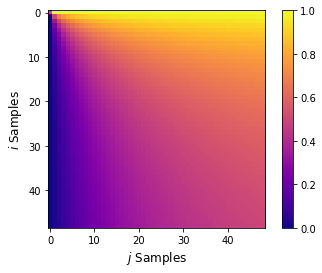

In [6]:
#plt.figure(figsize=(10,10))
im = plt.imshow(i_j[1:50,1:50],cmap="plasma")
plt.colorbar()
xlabel = plt.xlabel("$\it{j}$ Samples",fontsize=12)
ylabel = plt.ylabel("$\it{i}$ Samples",fontsize=12)
plt.savefig('heatmap_smaller_label.eps', format='eps', dpi=200,bbox_extra_artists=(xlabel,ylabel), bbox_inches='tight')

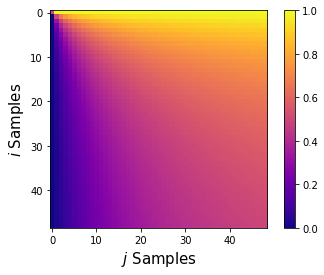

In [17]:
#plt.figure(figsize=(10,10))
im = plt.imshow(i_j[1:50,1:50],cmap="plasma")
plt.colorbar()
xlabel = plt.xlabel("$\it{j}$ Samples",fontsize=15)
ylabel = plt.ylabel("$\it{i}$ Samples",fontsize=15)
plt.savefig('heatmap.eps', format='eps', dpi=200,bbox_extra_artists=(xlabel,ylabel), bbox_inches='tight')

In [37]:
total_val = 0
for i in range(1,50):
    for j in range(1,50):
        total_val += 1/(i*j)

In [38]:
theta = 1/total_val

In [221]:
new_sum = 0
for i in range(1,20):
    for j in range(1,20):
        new_sum += theta/((i*j))

In [232]:
q_bar = 0
for i in range(1,20):
    for j in range(1,20):
        q_bar += theta/((i*j)) * i_j_30[i,j]

In [40]:
q_bar = 0
for i in range(1,50):
    for j in range(1,50):
        if i <= j:
            q_bar += theta/((i*j)) * i_j[i,j]
        else:
            q_bar += theta/((i*j)) * (1-i_j[i,j])

In [41]:
q_bar

0.8240836808549863

In [230]:
theta

0.0794504780679531

In [234]:
simulation = msprime.simulate(sample_size=50, Ne=10000, length=150000, recombination_rate=2e-8, mutation_rate=2e-8)

In [246]:
freqs = list()
for variant in simulation.variants():
    freqs.append(np.sum(variant.genotypes == 1)/len(variant.genotypes))

(array([316.,  86.,  32.,  12.,  17.,  24.,  21.,  21.,  24.,  31.]),
 array([0.02 , 0.116, 0.212, 0.308, 0.404, 0.5  , 0.596, 0.692, 0.788,
        0.884, 0.98 ]),
 <a list of 10 Patch objects>)

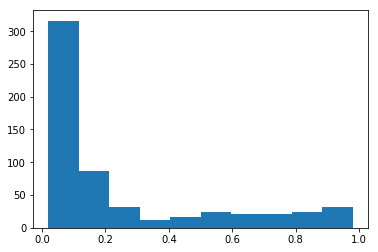

In [252]:
plt.hist(freqs)

# Checking the empirical error model

In [190]:
simulation = msprime.simulate(sample_size=50, Ne=10000, length=100000, recombination_rate=2e-8, mutation_rate=2e-8)
sample_data=generate_samples(simulation,"samples_files",0,True)
sample_data_error=generate_samples_genotype(simulation,"error_samples_files")

In [191]:
wrong = 0
right = 0
for i in range(0,len(list(simulation.variants()))):
    if not (np.logical_and( (list(simulation.variants())[i].genotypes==sample_data.sites_genotypes[i]).all(), 
    (sample_data.sites_genotypes[i]==sample_data_error.sites_genotypes[i]).all() )):
        print("Variant number", i)
        print(list(simulation.variants())[i].genotypes)
        print(sample_data.sites_genotypes[i])
        print(sample_data_error.sites_genotypes[i])
        print(np.argwhere(np.not_equal(sample_data.sites_genotypes[i],sample_data_error.sites_genotypes[i])==True))
        wrong += 1
    else:
        right += 1

Variant number 15
[0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0
 1 0 0 0 1 1 1 1 1 1 1 1 0]
[0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0
 1 0 0 0 1 1 1 1 1 1 1 1 0]
[0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 0]
[[34]
 [38]
 [39]]
Variant number 17
[0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 0]
[0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 0]
[0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 0]
[[34]]
Variant number 31
[0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 0]
[0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 0]
[0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 

Variant number 264
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0
 1 1 0 0 1 0 0 1 1 0 1 1 1]
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0
 1 1 0 0 1 0 0 1 1 0 1 1 1]
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0
 1 1 1 0 1 0 0 1 1 0 1 1 1]
[[39]]
Variant number 269
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1
 1 1 1 0 1 0 0 1 1 0 1 1 1]
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1
 1 1 1 0 1 0 0 1 1 0 1 1 1]
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 0 1 0 0 1 1 0 1 1 1]
[[26]
 [27]]
Variant number 296
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 0 1 1 0 0 1 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 0 1 1 0 0 1 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 0 1 1 0 0 1 0 0

In [192]:
wrong

37

In [195]:
right*50 + ((wrong -1) *49)

18514

# GEVA Reimplementation

In [21]:
def msprime_simulation(name,sample_size, Ne, length, recombination_rate, mutation_rate):
    #Step one: simulate dataset with msprime
    simulation = msprime.simulate(sample_size=sample_size, Ne=Ne, length=length, recombination_rate=recombination_rate, mutation_rate=mutation_rate)
    with open("../tmp/"+name+".vcf", "w") as vcf_file:
        simulation.write_vcf(vcf_file, 2)
    return(simulation)

In [22]:
def make_errors_genotype_model(g, error_matrix):
    """
    Given an empirically estimated error matrix, resample for a particular
    variant. Given a true genotype of g0, g1, or g2, return observed genotype
    depending on the error_matrix. For example, given a variant with genotype
    g0, return g0 with probability 99.942%, g1 with probability 0.041%, and
    g2 with probability 0.017%. Treat each pair of alleles as a diploid 
    individual. 
    """

    w = np.copy(g)
    #Make diploid (iterate each pair of alleles)
    genos=[(w[i],w[i+1]) for i in range(0,w.shape[0],2)]
    #Record the true genotypes
    g0 = [i for i, x in enumerate(genos) if x == (0,0)]
    g1a = [i for i, x in enumerate(genos) if x == (1,0)]
    g1b = [i for i, x in enumerate(genos) if x == (0,1)]
    g2 = [i for i, x in enumerate(genos) if x == (1,1)]

    for idx in g0:
        result=random.choices(
            [(0,0),(1,0),(1,1)], weights=error_matrix[['p00','p01','p02']].values[0])
        if result == (1,0):
            genos[idx]=random.choices([(0,1),(1,0)])
        else:
            genos[idx] = result

    for idx in g1a:
        genos[idx]=random.choices(
            [(0,0),(1,0),(1,1)], weights=error_matrix[['p10','p11','p12']].values[0])

    for idx in g1b:
        genos[idx]=random.choices(
            [(0,0),(0,1),(1,1)], weights=error_matrix[['p10','p11','p12']].values[0])

    for idx in g2:
        result=random.choices(
            [(0,0),(1,0),(1,1)], weights=error_matrix[['p20','p21','p22']].values[0])

        if result == (1,0):
            genos[idx]=random.choices([(0,1),(1,0)])

        else:
            genos[idx] = result
        
    return(np.array(sum([chromo for tup in genos for chromo in tup], ())))
    
    

def generate_samples_empirical(ts, filename, error_matrix):

    """
    Generate a samples file from a simulated ts based on an empirically estimated error matrix
    Reject any variants that result in a fixed column. 
    """

    error_matrix=pd.read_csv(error_matrix)
    record_rate = logging.getLogger().isEnabledFor(logging.INFO)
    n_variants = bits_flipped = 0
    assert ts.num_sites != 0
    sample_data = tsinfer.SampleData(
        path="../data/"+filename + "/"+filename+".samples",
        sequence_length=ts.sequence_length)
    for v in ts.variants():
        n_variants += 1
        #Record the allele frequency
        m = v.genotypes.shape[0]
        frequency = np.sum(v.genotypes) / m

        #Find closest row in error matrix file
        closest_freq = error_matrix.iloc[(error_matrix['freq']-frequency).abs().argsort()[:1]]

        #make new genotypes with error
        # Reject any columns that have no 1s or no zeros.
        # Unless the original also has them, as occasionally we have
        # some sims (e.g. under selection) where a variant is fixed
        while True:
            genotypes = make_errors_genotype_model(v.genotypes,closest_freq)
            s = np.sum(genotypes)
            if 0 < s < ts.sample_size:
                break
            if s == np.sum(v.genotypes):
                break
        if record_rate:
            bits_flipped += np.sum(np.logical_xor(genotypes, v.genotypes))
        sample_data.add_site(
            position=v.site.position, alleles=v.alleles,
            genotypes=genotypes)
    logging.info(": actual error rate = {}".format(
            bits_flipped/(n_variants*ts.sample_size)) if record_rate else "")
    sample_data.finalise()
    return sample_data

In [23]:
def geva_age_estimate(file_name,ne,rec_rate,mut_rate):
    subprocess.check_output(["/home/wilderwohns/relative_allele_age/bin/geva/geva_v1beta", '--vcf', file_name+".vcf","--rec", rec_rate, "--out","../tmp/"+file_name])
    with open("../tmp/"+file_name+".positions.txt","wb") as out:
        subprocess.call(["awk", "NR>3 {print last} {last = $3}", "../tmp/"+file_name+".marker.txt"], stdout=out)
    try:
        subprocess.call(["/home/wilderwohns/relative_allele_age/bin/geva/geva_v1beta", "-i", "../tmp/"+ file_name+".bin", "--positions", "../tmp/"+file_name+".positions.txt","--hmm","/home/wilderwohns/relative_allele_age/bin/geva/hmm/hmm_initial_probs.txt ","/home/wilderwohns/relative_allele_age/bin/geva/hmm/hmm_emission_probs.txt","--Ne", ne, "--mut", mut_rate,"-o","../tmp/"+file_name+"_estimation"])
    except subprocess.CalledProcessError as grepexc:
        print(grepexc.output)
    age_estimates = pd.read_csv("../tmp/"+file_name+"_estimation.sites.txt", sep = " ")
    return(age_estimates)

In [24]:
#I compared with geva_age_estimate and it's good
def geva_with_error(name,sample_data,Ne,length,mut_rate):
    
    num_individuals = len(sample_data.individuals_metadata[:])
    ind_list = list()
    pos_geno_dict = {"POS":list()}

    for i in range(int(num_individuals/2)):
        pos_geno_dict["msp_"+str(i)] = list()
        ind_list.append("msp_"+str(i))

    #add all the sample positions and genotypes
    for i in sample_data.genotypes():
        pos_geno_dict["POS"].append(int(round(sample_data.sites_position[i[0]])))
        for j in range(0,len(i[1]),2):

            pos_geno_dict["msp_"+str(int(j/2))].append(str(i[1][j]) + "|" + str(i[1][j+1]))

    df = pd.DataFrame(pos_geno_dict)

    df["#CHROM"] = 1
    df["REF"] = "A"
    df["ALT"] = "T"
    df['ID'] = "."
    df['QUAL'] = "."
    df['FILTER'] = "PASS"
    df['INFO'] = "."
    df['FORMAT'] = "GT"

    cols = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO','FORMAT']+ind_list
    df = df[cols] 

    header = """##fileformat=VCFv4.2
##source=msprime 0.6.0
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=""" + str(int(length)) +  """>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
"""
    
    output_VCF = "../tmp/"+name+".vcf"
    with open(output_VCF, 'w') as vcf:
        vcf.write(header)

    df.to_csv(output_VCF, sep="\t", mode='a',index=False)
    
    return(geva_age_estimate("../tmp/"+name,"10000","2e-8","2e-8"))

In [25]:
agree_overall_distances = list()
disagree_overall_distances = list()
baseline_overall_distances = list()

agree_overall_distances_error = list()
disagree_overall_distances_error = list()
baseline_overall_distances_error = list()

agree_overall_freq_diff = list()
disagree_overall_freq_diff = list()
baseline_overall_freq_diff = list()

agree_overall_freq_diff_error = list()
disagree_overall_freq_diff_error = list()
baseline_overall_freq_diff_error = list()

analytical_prediction_bins = defaultdict(list)
analytical_prediction_bins_error = defaultdict(list)

agree_overall_distances_geva = list()
disagree_overall_distances_geva = list()
baseline_overall_distances_geva = list()

agree_overall_distances_error_geva = list()
disagree_overall_distances_error_geva = list()
baseline_overall_distances_error_geva = list()

agree_overall_freq_diff_geva = list()
disagree_overall_freq_diff_geva = list()
baseline_overall_freq_diff_geva = list()

agree_overall_freq_diff_error_geva = list()
disagree_overall_freq_diff_error_geva = list()
baseline_overall_freq_diff_error_geva = list()

analytical_prediction_bins_geva = defaultdict(list)
analytical_prediction_bins_error_geva = defaultdict(list)

In [26]:
double_accurate=0
double_false=0
double_accurate_error=0
double_false_error=0
two_method_disagree=0
two_method_disagree_error=0

In [32]:
for i in tqdm(range(0,200,1)):
    simulation = msprime_simulation("geva_test", 50, 10000, 25000, 2e-8, 2e-8)
    sample_data_error = generate_samples_empirical(simulation)
    sample_data = generate_samples(simulation)
    print("here")
    age_estimates = geva_with_error("no_error",sample_data,10000,2e-8,2e-8)
    print("first done")
    age_estimates_error = geva_with_error("error",sample_data_error,10000,2e-8,2e-8)
    print("second done")
    num_mutations = len(sample_data.sites_genotypes[:])

    variant_ages = [(mutation.id,simulation.node(mutation.node).time) for mutation in list(simulation.mutations())]

    variant_frequencies = [len(geno[geno==1])/len(geno) for geno in sample_data.sites_genotypes[:]]
    variant_frequencies_error = [len(geno[geno==1])/len(geno) for geno in sample_data_error.sites_genotypes[:]]
    variant_nums = [len(geno[geno==1]) for geno in sample_data.sites_genotypes[:]]
    variant_nums_error = [len(geno[geno==1]) for geno in sample_data_error.sites_genotypes[:]]
    mutation_positions=[mutation.position for mutation in list(simulation.mutations())]
    try:
        assert(len(sample_data.sites_genotypes[:]) == len(sample_data_error.sites_genotypes[:]) == len(variant_ages) == len(variant_frequencies)
            == len(variant_frequencies_error) == len(mutation_positions))
    except AssertionError as error:
        print(len(sample_data.sites_genotypes[:]),len(sample_data_error.sites_genotypes[:]), len(variant_ages), len(variant_frequencies), len(variant_frequencies_error), len(mutation_positions))

    for combo in list(itertools.combinations(range(0,num_mutations),2)):
        if (combo[0] != 0) & (combo[1] != 0) and (combo[0] != num_mutations - 1) and (combo[1] != num_mutations -1):
            freq1 = variant_frequencies[combo[0]]
            freq2 = variant_frequencies[combo[1]]
            freq1_error = variant_frequencies_error[combo[0]]
            freq2_error = variant_frequencies_error[combo[1]]

            age1 = variant_ages[combo[0]]
            age2 = variant_ages[combo[1]]

            freq_diff = abs(freq1 - freq2)
            freq_diff_error = abs(freq1_error - freq2_error)
            distance = abs(mutation_positions[combo[0]] - mutation_positions[combo[1]])
            
            if (age1[1] != age2[1]):
                
                if (combo[0] in age_estimates.MarkerID.values) and (combo[1] in age_estimates.MarkerID.values):
                    geva_estimate_1 = age_estimates[(age_estimates.MarkerID == combo[0]) & (age_estimates.Filtered == 1) & (age_estimates.Clock == "J")].PostMode.values[0]
                    geva_estimate_2 = age_estimates[(age_estimates.MarkerID == combo[1]) & (age_estimates.Filtered == 1) & (age_estimates.Clock == "J")].PostMode.values[0]
                    
                     ###
                    if ((freq1 < freq2) == (geva_estimate_1 < geva_estimate_2)):
                        if (age1[1] < age2[1]) == (freq1 < freq2) == (geva_estimate_1 < geva_estimate_2):
                            double_accurate += 1
                        else:
                            double_false += 1
                    else:
                        two_method_disagree +=1
                    
                    ####
                    
                    if (freq1 != freq2):
                        if ((age1[1] < age2[1]) == (freq1 < freq2)):
                            agree_overall_freq_diff.append(freq_diff)
                            agree_overall_distances.append(distance)
                        else:
                            disagree_overall_freq_diff.append(freq_diff)
                            disagree_overall_distances.append(distance)

                        baseline_overall_distances.append(distance)
                        baseline_overall_freq_diff.append(freq_diff)

#                         if variant_nums[combo[0]] < variant_nums[combo[1]]:
#                             analytical_prediction_bins[int(distance/1000)].append(analytical_result_51[variant_nums[combo[0]],50-variant_nums[combo[0]],variant_nums[combo[1]],50-variant_nums[combo[1]]])
#                         else: 
#                             analytical_prediction_bins[int(distance/1000)].append(analytical_result_51[variant_nums[combo[1]],50-variant_nums[combo[1]],variant_nums[combo[0]],50-variant_nums[combo[0]]])
                    else:
                        if (random.choice([True, False])):
                            agree_overall_freq_diff.append(freq_diff)
                            agree_overall_distances.append(distance)

                        else:
                            disagree_overall_freq_diff.append(freq_diff)
                            disagree_overall_distances.append(distance)

                        baseline_overall_distances.append(distance)
                        baseline_overall_freq_diff.append(freq_diff)

#                         analytical_prediction_bins[int(distance/1000)].append(analytical_result_51[variant_nums[combo[0]],50-variant_nums[combo[0]],variant_nums[combo[1]],50-variant_nums[combo[1]]])

                    if (geva_estimate_1 != geva_estimate_2):
                        if ((age1[1] < age2[1]) == (geva_estimate_1 < geva_estimate_2)):
                            agree_overall_freq_diff_geva.append(freq_diff)
                            agree_overall_distances_geva.append(distance)
                        else:
                            disagree_overall_freq_diff_geva.append(freq_diff)
                            disagree_overall_distances_geva.append(distance)

                        baseline_overall_distances_geva.append(distance)
                        baseline_overall_freq_diff_geva.append(freq_diff)

#                         if variant_nums[combo[0]] < variant_nums[combo[1]]:
#                             analytical_prediction_bins_geva[int(distance/1000)].append(analytical_result_51[variant_nums[combo[0]],50-variant_nums[combo[0]],variant_nums[combo[1]],50-variant_nums[combo[1]]])
#                         else: 
#                             analytical_prediction_bins_geva[int(distance/1000)].append(analytical_result_51[variant_nums[combo[1]],50-variant_nums[combo[1]],variant_nums[combo[0]],50-variant_nums[combo[0]]])
                    else:
                        if (random.choice([True, False])):
                            agree_overall_freq_diff_geva.append(freq_diff)
                            agree_overall_distances_geva.append(distance)
                        else:
                            disagree_overall_freq_diff_geva.append(freq_diff)
                            disagree_overall_distances_geva.append(distance) 

                        baseline_overall_distances_geva.append(distance)
                        baseline_overall_freq_diff_geva.append(freq_diff_error)

#                         analytical_prediction_bins_geva[int(distance/1000)].append(analytical_result_51[variant_nums_error[combo[0]],50-variant_nums_error[combo[0]],variant_nums_error[combo[1]],50-variant_nums_error[combo[1]]])

                    
                if (combo[0] in age_estimates_error.MarkerID.values) and (combo[1] in age_estimates_error.MarkerID.values):
                    geva_estimate_error_1 = age_estimates_error[(age_estimates_error.MarkerID == combo[0]) & (age_estimates_error.Filtered == 1) & (age_estimates_error.Clock == "J")].PostMode.values[0]
                    geva_estimate_error_2 = age_estimates_error[(age_estimates_error.MarkerID == combo[1]) & (age_estimates_error.Filtered == 1) & (age_estimates_error.Clock == "J")].PostMode.values[0]

                     ###
                    if ((freq1_error < freq2_error) == (geva_estimate_error_1 < geva_estimate_error_2)):
                        if (age1[1] < age2[1]) == (freq1_error < freq2_error) == (geva_estimate_error_1 < geva_estimate_error_2):
                            double_accurate_error += 1
                        else:
                            double_false_error += 1
                    else:
                        two_method_disagree_error +=1
                    ####
                    if (freq1_error != freq2_error):
                        if ((age1[1] < age2[1]) == (freq1_error < freq2_error)):
                            agree_overall_freq_diff_error.append(freq_diff_error)
                            agree_overall_distances_error.append(distance)

                        else:
                            disagree_overall_freq_diff_error.append(freq_diff_error)
                            disagree_overall_distances_error.append(distance)

                        baseline_overall_distances_error.append(distance)
                        baseline_overall_freq_diff_error.append(freq_diff_error)

#                         if variant_nums_error[combo[0]] < variant_nums_error[combo[1]]:
#                             analytical_prediction_bins_error[int(distance/1000)].append(analytical_result_51[variant_nums_error[combo[0]],50-variant_nums_error[combo[0]],variant_nums_error[combo[1]],50-variant_nums_error[combo[1]]])
#                         else: 
#                             analytical_prediction_bins_error[int(distance/1000)].append(analytical_result_51[variant_nums_error[combo[1]],50-variant_nums_error[combo[1]],variant_nums_error[combo[0]],50-variant_nums_error[combo[0]]])

                    else:
                        if (random.choice([True, False])):
                            agree_overall_freq_diff_error.append(freq_diff)
                            agree_overall_distances_error.append(distance)
                        else:
                            disagree_overall_freq_diff_error.append(freq_diff)
                            disagree_overall_distances_error.append(distance) 

                        baseline_overall_distances_error.append(distance)
                        baseline_overall_freq_diff_error.append(freq_diff_error)

#                         analytical_prediction_bins_error[int(distance/1000)].append(analytical_result_51[variant_nums_error[combo[0]],50-variant_nums_error[combo[0]],variant_nums_error[combo[1]],50-variant_nums_error[combo[1]]])

                    if (geva_estimate_error_1 != geva_estimate_error_2):
                        if ((age1[1] < age2[1]) == (geva_estimate_error_1 < geva_estimate_error_2)):
                            agree_overall_freq_diff_error_geva.append(freq_diff)
                            agree_overall_distances_error_geva.append(distance)
                        else:
                            disagree_overall_freq_diff_error_geva.append(freq_diff)
                            disagree_overall_distances_error_geva.append(distance)

                        baseline_overall_distances_error_geva.append(distance)
                        baseline_overall_freq_diff_error_geva.append(freq_diff)

#                         if variant_nums[combo[0]] < variant_nums[combo[1]]:
#                             analytical_prediction_bins_error_geva[int(distance/1000)].append(analytical_result_51[variant_nums[combo[0]],50-variant_nums[combo[0]],variant_nums[combo[1]],50-variant_nums[combo[1]]])
#                         else: 
#                             analytical_prediction_bins_error_geva[int(distance/1000)].append(analytical_result_51[variant_nums[combo[1]],50-variant_nums[combo[1]],variant_nums[combo[0]],50-variant_nums[combo[0]]])
                    else:
                        if (random.choice([True, False])):
                            agree_overall_freq_diff_error_geva.append(freq_diff)
                            agree_overall_distances_error_geva.append(distance)
                        else:
                            disagree_overall_freq_diff_error_geva.append(freq_diff)
                            disagree_overall_distances_error_geva.append(distance) 

                        baseline_overall_distances_error_geva.append(distance)
                        baseline_overall_freq_diff_error_geva.append(freq_diff_error)

#                         analytical_prediction_bins_error_geva[int(distance/1000)].append(analytical_result_51[variant_nums_error[combo[0]],50-variant_nums_error[combo[0]],variant_nums_error[combo[1]],50-variant_nums_error[combo[1]]])


HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

here
first done



Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/wilderwohns/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/wilderwohns/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/wilderwohns/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



second done
here
first done



KeyboardInterrupt: 

In [195]:
average_predicted_values = list()
for i in range(1,50,1):
    average_predicted_values.append(np.mean(analytical_prediction_bins[i]))
    
average_predicted_values_error = list()
for i in range(1,50,1):
    average_predicted_values_error.append(np.nanmean(analytical_prediction_bins_error[i]))
    
average_predicted_values_geva = list()
for i in range(1,50,1):
    average_predicted_values_geva.append(np.mean(analytical_prediction_bins_geva[i]))
    
average_predicted_values_error_geva = list()
for i in range(1,50,1):
    average_predicted_values_error_geva.append(np.nanmean(analytical_prediction_bins_error_geva[i]))

/home/wilderwohns/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/wilderwohns/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wilderwohns/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/wilderwohns/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [196]:
bins = np.linspace(0, 50000, 51)
digitized_baseline = np.digitize(baseline_overall_distances, bins)
digitized_disagree = np.digitize(disagree_overall_distances, bins)
digitized_agree = np.digitize(agree_overall_distances, bins)

baseline_counts = np.unique(digitized_baseline, return_counts=True)
disagree_counts = np.unique(digitized_disagree, return_counts=True)
agree_counts = np.unique(digitized_agree, return_counts=True)

results = [agree_counts[1][agree_counts[0] == count[0]][0]/count[1] for count in zip(baseline_counts[0],baseline_counts[1]) if count[0] in agree_counts[0]]

digitized_baseline_error = np.digitize(baseline_overall_distances_error, bins)
digitized_disagree_error = np.digitize(disagree_overall_distances_error, bins)
digitized_agree_error = np.digitize(agree_overall_distances_error, bins)

baseline_counts_error = np.unique(digitized_baseline_error, return_counts=True)
disagree_counts_error = np.unique(digitized_disagree_error, return_counts=True)
agree_counts_error = np.unique(digitized_agree_error, return_counts=True)

results_error = [agree_counts_error[1][agree_counts_error[0] == count[0]][0]/count[1] for count in zip(baseline_counts_error[0],baseline_counts_error[1]) if count[0] in agree_counts_error[0]]


In [197]:
bins = np.linspace(0, 50000, 51)
digitized_baseline_geva = np.digitize(baseline_overall_distances_geva, bins)
digitized_disagree_geva = np.digitize(disagree_overall_distances_geva, bins)
digitized_agree_geva = np.digitize(agree_overall_distances_geva, bins)

baseline_counts_geva = np.unique(digitized_baseline_geva, return_counts=True)
disagree_counts_geva = np.unique(digitized_disagree_geva, return_counts=True)
agree_counts_geva = np.unique(digitized_agree_geva, return_counts=True)

results_geva = [agree_counts_geva[1][agree_counts_geva[0] == count[0]][0]/
                count[1] for count in zip(baseline_counts_geva[0],baseline_counts_geva[1]) 
                if count[0] in agree_counts_geva[0]]

digitized_baseline_error_geva = np.digitize(baseline_overall_distances_error_geva, bins)
digitized_disagree_error_geva = np.digitize(disagree_overall_distances_error_geva, bins)
digitized_agree_error_geva = np.digitize(agree_overall_distances_error_geva, bins)

baseline_counts_error_geva = np.unique(digitized_baseline_error_geva, return_counts=True)
disagree_counts_error_geva = np.unique(digitized_disagree_error_geva, return_counts=True)
agree_counts_error_geva = np.unique(digitized_agree_error_geva, return_counts=True)

results_error_geva = [agree_counts_error_geva[1][agree_counts_error_geva[0] == count[0]][0]/
                      count[1] for count in zip(baseline_counts_error_geva[0],baseline_counts_error_geva[1])
                      if count[0] in agree_counts_error_geva[0]]


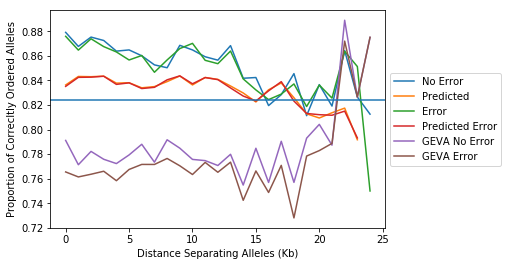

In [198]:
#don't consider any of the same age, flip coin for same frequency
plt.plot(results,label="No Error")


plt.xlabel("Distance Separating Alleles (Kb)")
plt.ylabel("Proportion of Correcltly Ordered Alleles")
plt.plot(average_predicted_values, label="Predicted")

plt.plot(results_error,label="Error")
plt.plot(average_predicted_values_error,label="Predicted Error")
plt.plot(results_geva,label="GEVA No Error")
plt.plot(results_error_geva,label="GEVA Error")

plt.axhline(y=0.8240836808549863)
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("freq_geva_error_distance_accuracy", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [18]:
#freq no error accuracy
print("freq no error accuracy",len(agree_overall_distances)/len(baseline_overall_distances))

#freq error accuracy
print("freq error accuracy",len(agree_overall_distances_error)/len(baseline_overall_distances_error))

#geva_accuracy
print("geva_accuracy",len(agree_overall_distances_geva)/len(baseline_overall_distances_geva))

#geva_accuracy error
print("geva_accuracy error",len(agree_overall_distances_error_geva)/len(baseline_overall_distances_error_geva))

print("If Freq and GEVA agree:",double_accurate/(double_accurate+ double_false))
print("If Freq and GEVA agree error:",double_accurate_error/(double_accurate_error+double_false_error))

freq no error accuracy 0.8408576375016646
freq error accuracy 0.8442870261052079
geva_accuracy 0.7902516979624451
geva_accuracy error 0.7927325200052473
If Freq and GEVA agree: 0.883032373515536
If Freq and GEVA agree error: 0.8906627963231737


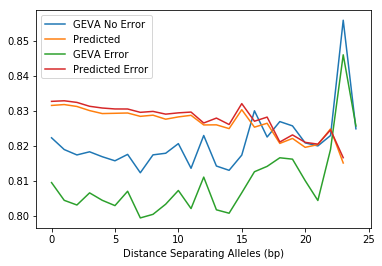

In [145]:
#Just geva
plt.plot(results_geva,label="GEVA No Error")


plt.xlabel("Distance Separating Alleles (bp)")
plt.plot(average_predicted_values_geva, label="Predicted")

plt.plot(results_error_geva,label="GEVA Error")
plt.plot(average_predicted_values_error_geva,label="Predicted Error")


plt.legend()

In [147]:
bins = np.linspace(0, 1, 21)
digitized_baseline_freq_diff = np.digitize(baseline_overall_freq_diff, bins)
digitized_disagree_freq_diff = np.digitize(disagree_overall_freq_diff, bins)
digitized_agree_freq_diff = np.digitize(agree_overall_freq_diff, bins)

baseline_counts_freq_diff = np.unique(digitized_baseline_freq_diff, return_counts=True)
disagree_counts_freq_diff = np.unique(digitized_disagree_freq_diff, return_counts=True)
agree_counts_freq_diff = np.unique(digitized_agree_freq_diff, return_counts=True)

results_freq_diff = [agree_counts_freq_diff[1][agree_counts_freq_diff[0] == count[0]][0]/count[1] for count in zip(baseline_counts_freq_diff[0],baseline_counts_freq_diff[1]) if count[0] in agree_counts_freq_diff[0]]

digitized_baseline_error_freq_diff = np.digitize(baseline_overall_freq_diff_error, bins)
digitized_disagree_error_freq_diff = np.digitize(disagree_overall_freq_diff_error, bins)
digitized_agree_error_freq_diff = np.digitize(agree_overall_freq_diff_error, bins)

baseline_counts_error_freq_diff = np.unique(digitized_baseline_error_freq_diff, return_counts=True)
disagree_counts_error_freq_diff = np.unique(digitized_disagree_error_freq_diff, return_counts=True)
agree_counts_error_freq_diff = np.unique(digitized_agree_error_freq_diff, return_counts=True)

results_error_freq_diff = [agree_counts_error_freq_diff[1][agree_counts_error_freq_diff[0] == count[0]][0]/count[1] for count in zip(baseline_counts_error_freq_diff[0],baseline_counts_error_freq_diff[1]) if count[0] in agree_counts_error_freq_diff[0]]


Text(0,0.5,'Correct Assignment of Relative Allele Age')

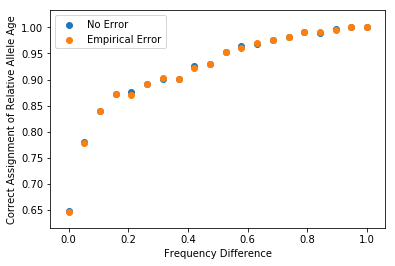

In [205]:
plt.scatter(np.linspace(0,1,20),results_freq_diff,label="No Error")
plt.scatter(np.linspace(0,1,20),results_error_freq_diff,label="Empirical Error")
plt.legend()
plt.xlabel("Frequency Difference")
plt.ylabel("Correct Assignment of Relative Allele Age")
#predicted_vals = DefaultDict(list)
# for diff in np.linspace(0,1,19):
#     for i in range(1,50):
#         for j in range(1,50):
#             if ((i/50) - diff)* 50 == j:
#                 predicted_vals[diff].append(i_j[i,j])

In [53]:
np.linspace(0,1,100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [65]:
predicted_means = list()
for key,value in predicted_vals.items():
    predicted_means.append(np.nanmean(value))

/home/wilderwohns/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
predicted_means

[0.5287862592580413,
 0.54385527954419,
 0.5570005556023578,
 0.5689013258467287,
 0.5799218303968472,
 0.5902855204209803,
 0.6001421745212743,
 0.6095987092178016,
 0.6187351455753867,
 0.6276136516197369,
 0.6362840229578658,
 0.6447871877239777,
 0.6531575480551249,
 0.6614246022904798,
 0.6696141042946191,
 0.6777489147330784,
 0.6858496414419077,
 0.6939351318796498,
 0.7020228596909346,
 0.7101292341383704,
 0.7182698525164988,
 0.7264597098880498,
 0.7347133765309629,
 0.7430451507112044,
 0.7514691923929027,
 0.759999641994506,
 0.7686507271098496,
 0.7774368590942867,
 0.7863727204462803,
 0.7954733428704067,
 0.8047541746400899,
 0.8142311341836015,
 0.8239206443878029,
 0.8338396384606014,
 0.8440055224996694,
 0.854436070778562,
 0.8651492146890455,
 0.8761626606904002,
 0.8874932277851956,
 0.8991557136373493,
 0.9111609444144033,
 0.9235123575858664,
 0.9361998240609712,
 0.949187969784246,
 0.9623927231763807,
 0.9756302525841879,
 0.9884930044414714,
 1.0,
 nan,
 nan]

(0.5, 1)

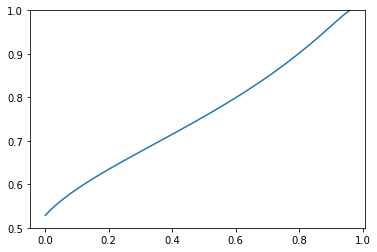

In [67]:
plt.plot(predicted_vals.keys(),predicted_means)
plt.ylim(0.5,1)

In [68]:
np.linspace(0,1,50)[2]-np.linspace(0,1,50)[1]

0.02040816326530612

In [64]:
predicted_vals = {key: list() for key in np.linspace(0,1,50)}
for diff in np.linspace(0,1,50):
    for i in range(1,50):
        for j in range(1,50):
            if (i/50) - (j/50) > diff and (i/50) - (j/50) < diff + 0.02040816326530612:
                if j <= i:
                    predicted_vals[diff].append(1- i_j[i,j])
                else:
                    predicted_vals[diff].append(i_j[i,j])

# For tsinfer paper


In [28]:
random.seed(a=23)
error_matrix=pd.read_csv("/home/wilderwohns/tsinfer_paper/data/EmpiricalErrorPlatinum1000G.csv")

def make_errors_genotype_model(g, error_matrix):
    """
    Given an empirically estimated error matrix, resample for a particular
    variant. Given a true genotype of g0, g1, or g2, return observed genotype
    depending on the error_matrix. For example, given a variant with genotype
    g0, return g0 with probability 99.942%, g1 with probability 0.041%, and
    g2 with probability 0.017%. Treat each pair of alleles as a diploid 
    individual. 
    """

    w = np.copy(g)
    #Make diploid (iterate each pair of alleles)
    genos=[(w[i],w[i+1]) for i in range(0,w.shape[0],2)]
    #Record the true genotypes
    g0 = [i for i, x in enumerate(genos) if x == (0,0)]
    g1a = [i for i, x in enumerate(genos) if x == (1,0)]
    g1b = [i for i, x in enumerate(genos) if x == (0,1)]
    g2 = [i for i, x in enumerate(genos) if x == (1,1)]

    for idx in g0:
        result=random.choices(
            [(0,0),(1,0),(1,1)], weights=error_matrix[['p00','p01','p02']].values[0])
        if result == (1,0):
            genos[idx]=random.choices([(0,1),(1,0)])
        else:
            genos[idx] = result

    for idx in g1a:
        genos[idx]=random.choices(
            [(0,0),(1,0),(1,1)], weights=error_matrix[['p10','p11','p12']].values[0])

    for idx in g1b:
        genos[idx]=random.choices(
            [(0,0),(0,1),(1,1)], weights=error_matrix[['p10','p11','p12']].values[0])

    for idx in g2:
        result=random.choices(
            [(0,0),(1,0),(1,1)], weights=error_matrix[['p20','p21','p22']].values[0])

        if result == (1,0):
            genos[idx]=random.choices([(0,1),(1,0)])

        else:
            genos[idx] = result
        
    return(np.array(sum([chromo for tup in genos for chromo in tup], ())))
    
    

def generate_samples_empirical(ts):

    """
    Generate a samples file from a simulated ts based on an empirically estimated error matrix
    Reject any variants that result in a fixed column. 
    """

    
    record_rate = logging.getLogger().isEnabledFor(logging.INFO)
    n_variants = bits_flipped = 0
    assert ts.num_sites != 0
    sample_data = tsinfer.SampleData(sequence_length=ts.sequence_length)
    for v in ts.variants():
        n_variants += 1
        #Record the allele frequency
        m = v.genotypes.shape[0]
        frequency = np.sum(v.genotypes) / m

        #Find closest row in error matrix file
        closest_freq = error_matrix.iloc[(error_matrix['freq']-frequency).abs().argsort()[:1]]

        #make new genotypes with error
        # Reject any columns that have no 1s or no zeros.
        # Unless the original also has them, as occasionally we have
        # some sims (e.g. under selection) where a variant is fixed
        while True:
            genotypes = make_errors_genotype_model(v.genotypes,closest_freq)
            s = np.sum(genotypes)
            if 0 < s < ts.sample_size:
                break
            if s == np.sum(v.genotypes):
                break
        if record_rate:
            bits_flipped += np.sum(np.logical_xor(genotypes, v.genotypes))
        sample_data.add_site(
            position=v.site.position, alleles=v.alleles,
            genotypes=genotypes)
    logging.info(": actual error rate = {}".format(
            bits_flipped/(n_variants*ts.sample_size)) if record_rate else "")
    sample_data.finalise()
    return sample_data

def generate_samples(ts):
    """
    Generate a samples file from a simulated ts
    Samples may have bits flipped with a specified probability.
    (reject any variants that result in a fixed column)
    """

    assert ts.num_sites != 0
    
    sample_data = tsinfer.SampleData(sequence_length=ts.sequence_length)
    for v in ts.variants():
        sample_data.add_site(
            position=v.site.position, alleles=v.alleles,
            genotypes=v.genotypes)

    sample_data.finalise()
    return sample_data


def run_comparisons(sample_size,Ne,length,rec_rate,mut_rate,seed):
    simulation = msprime.simulate(sample_size=sample_size, Ne=Ne, length=length, recombination_rate=rec_rate, mutation_rate=mut_rate,random_seed=seed)
    sample_data = generate_samples(simulation)
    sample_data_error = generate_samples_empirical(simulation)
    num_mutations = len(sample_data.sites_genotypes[:])
    variant_ages = [(mutation.id,simulation.node(mutation.node).time) for mutation in list(simulation.mutations())]
    variant_frequencies = [len(geno[geno==1])/len(geno) for geno in sample_data.sites_genotypes[:]]
    variant_frequencies_error = [len(geno[geno==1])/len(geno) for geno in sample_data_error.sites_genotypes[:]]

    mutation_positions=[mutation.position for mutation in list(simulation.mutations())]
    
    for combo in list(itertools.combinations(range(0,num_mutations),2)):
        age1 = variant_ages[combo[0]]
        age2 = variant_ages[combo[1]]

        freq1 = variant_frequencies[combo[0]]
        freq2 = variant_frequencies[combo[1]]

        freq1_error = variant_frequencies_error[combo[0]]
        freq2_error = variant_frequencies_error[combo[1]]
        
        distance = abs(mutation_positions[combo[0]] - mutation_positions[combo[1]])
  
        
        if (age1[1] != age2[1]) and (freq1 != 1/sample_size) and (freq2 != 1/sample_size) and (freq1 != (1-sample_size)/sample_size) and (freq2 != (1-sample_size)/sample_size) and (freq1_error != 1/sample_size) and (freq2_error != 1/sample_size) and (freq1_error != (1-sample_size)/sample_size) and (freq2_error != (1-sample_size)/sample_size):
            results_total[distance//5000] += 1

            if freq1 < 0.02:
                print(freq1)
            if (freq1 != freq2):
                if ((age1[1] < age2[1]) == (freq1 < freq2)):
                    results_agree[distance//5000] += 1

            else:
                if (random.choice([True, False])):
                    results_agree[distance//5000] += 1


            #results_total_error[distance//5000] += 1

            if (freq1_error != freq2_error):
                if ((age1[1] < age2[1]) == (freq1_error < freq2_error)):
                    results_agree_error[distance//5000] += 1

            else:
                if (random.choice([True, False])):
                    results_agree_error[distance//5000] += 1



In [60]:
# results_total = {}
# results_agree = {}
# results_total_error = {}
# results_agree_error = {}

# for i in range(0,20):
#     results_total[i] = 0
#     results_agree[i] = 0
#     results_total_error[i] = 0
#     results_agree_error[i] = 0

In [61]:
random.seed(a=15)
seeds = list()
for i in range(0,1000):
    seeds.append(random.randint(0,100))

In [96]:
for i in tqdm(range(0,1000)): 
    run_comparisons(50,10000,100000,2e-8,2e-8,random.randint(0,2000))


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

KeyboardInterrupt: 

In [90]:
np.array(list(results_agree.values()))/np.array(list(results_total.values()))

array([0.8432618 , 0.83596815, 0.83176837, 0.82564139, 0.82492974,
       0.82499521, 0.82332701, 0.82558927, 0.82742389, 0.82502422,
       0.82344605, 0.82567677, 0.82863745, 0.83103044, 0.82912996,
       0.82387655, 0.82855511, 0.82357952, 0.82610055, 0.82969685])

In [91]:
np.array(list(results_agree_error.values()))/np.array(list(results_total.values()))

array([0.84239336, 0.83485206, 0.83127444, 0.82475333, 0.82541826,
       0.82408122, 0.82153038, 0.82437108, 0.82613583, 0.82367819,
       0.82218742, 0.82330523, 0.82699526, 0.83051263, 0.82716857,
       0.82192272, 0.82637374, 0.8242092 , 0.82647574, 0.82988994])

In [92]:
sum(list(results_agree.values()))/sum(list(results_total.values()))

0.8289336986428908

In [93]:
sum(list(results_agree_error.values()))/sum(list(results_total.values()))

0.8278934526721654

In [94]:
agree_df = pd.DataFrame.from_dict(results_agree, orient='index')
agree_df.columns = ["Agree"]
total_df = pd.DataFrame.from_dict(results_total, orient='index')
total_df.columns = ["Total"]
agree_error_df = pd.DataFrame.from_dict(results_agree_error, orient='index')
agree_error_df.columns = ["Error Agree"]
total_error_df = pd.DataFrame.from_dict(results_total_error, orient='index')
total_error_df.columns = ["Error Total"]
result_df = pd.concat([agree_df, total_df,agree_error_df,total_error_df], axis=1)

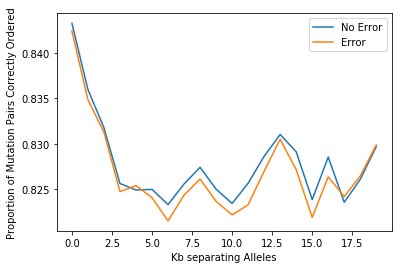

In [95]:
#Without SINGLETONS, don't consider any of the same age, flip coin for same frequency
plt.plot(result_df["Agree"]/result_df["Total"],label="No Error")

plt.plot(result_df["Error Agree"]/result_df["Total"],label="Error")
# plt.xlabel("Distance Separating Alleles (bp)")

plt.xlabel("Kb separating Alleles")
plt.ylabel("Proportion of Mutation Pairs Correctly Ordered")

plt.legend()

In [104]:
#result_df.to_csv("results_df.csv")

# GEVA reimplement comparison

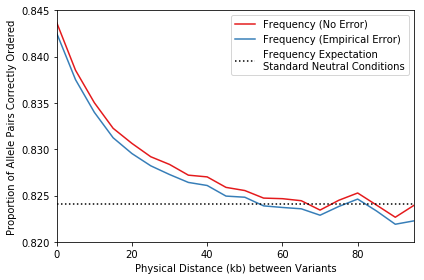

In [79]:
master_dataframe = pd.read_csv("/home/wilderwohns/geva_comparison/data/GEVA_frequency_distance_accuracy.csv")

plt.plot(range(0,100,5),master_dataframe.Agree/master_dataframe.Total,label="Frequency (No Error)",color="#e41a1c")
plt.plot(range(0,100,5),master_dataframe.AgreeError/master_dataframe.TotalError,label="Frequency (Empirical Error)",color="#377eb8")

plt.ylim(0.82,0.845)
plt.xlim(0,95)
plt.axhline(y=0.8240836808549863,color="black",linestyle=":",label="Frequency Expectation\nStandard Neutral Conditions")
plt.xlabel("Physical Distance (kb) between Variants")
plt.ylabel("Proportion of Allele Pairs Correctly Ordered")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
lgd = plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('frequency_distance.eps', format='eps', dpi=1000, bbox_extra_artists=(lgd,xlabel,ylabel), bbox_inches='tight')


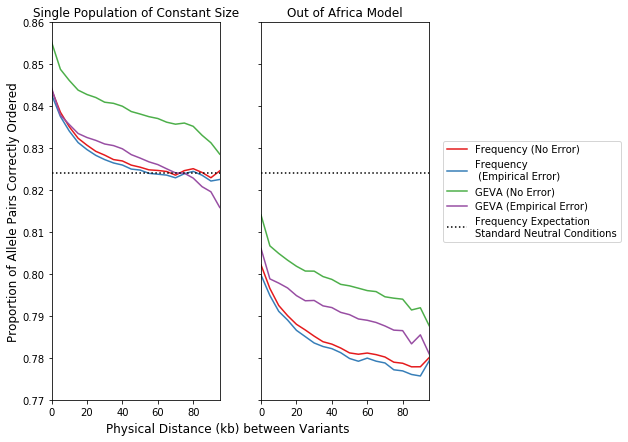

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(6, 6))
master_dataframe = pd.read_csv("/home/wilderwohns/geva_comparison/data/GEVA_frequency_distance_accuracy.csv")

ax[0].plot(range(0,100,5),master_dataframe.Agree/master_dataframe.Total,label="Frequency (No Error)",color="#e41a1c")
ax[0].plot(range(0,100,5),master_dataframe.AgreeError/master_dataframe.TotalError,label="Frequency\n (Empirical Error)",color="#377eb8")
ax[0].plot(range(0,100,5),master_dataframe.AgreeGeva/master_dataframe.Total,label="GEVA (No Error)",color="#4daf4a")
ax[0].plot(range(0,100,5),master_dataframe.AgreeGevaError/master_dataframe.TotalError,label="GEVA (Empirical Error)",color="#984ea3")

ax[0].set_ylim(0.77,0.86)
ax[0].set_xlim(0,95)
ax[0].axhline(y=0.8240836808549863,color="black",linestyle=":",label="Expectation for Accuracy of Frequency\n Under Standard Neutral Conditions")

#ax[0].set_xticks(np.arange(0, 20, step=4))
ax[0].set_title("Single Population of Constant Size")

ooa = pd.read_csv("/home/wilderwohns/out_of_africa_fig_transfer/data/GEVA_frequency_distance_accuracy.csv")

ax[1].plot(range(0,100,5),ooa.Agree/ooa.Total,label="Frequency (No Error)",color="#e41a1c")
ax[1].plot(range(0,100,5),ooa.AgreeError/ooa.TotalError,label="Frequency\n (Empirical Error)",color="#377eb8")
ax[1].plot(range(0,100,5),ooa.AgreeGeva/ooa.Total,label="GEVA (No Error)",color="#4daf4a")
ax[1].plot(range(0,100,5),ooa.AgreeGevaError/ooa.TotalError,label="GEVA (Empirical Error)",color="#984ea3")

ax[1].set_ylim(0.77,0.86)
ax[1].set_xlim(0,95)
ax[1].axhline(y=0.8240836808549863,color="black",linestyle=":",label="Frequency Expectation\nStandard Neutral Conditions")
ax[1].set_title("Out of Africa Model")

xlabel=fig.text(0.5, -0.01, "Physical Distance (kb) between Variants", ha='center',fontsize=12)
ylabel=fig.text(-0.01, 0.5, "Proportion of Allele Pairs Correctly Ordered", va='center', rotation='vertical',fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
lgd = plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(2.17, 0.7))
plt.tight_layout()
#plt.savefig('joined_geva_comparison_ooa_plots.eps', format='eps', dpi=1000, bbox_extra_artists=(lgd,xlabel,ylabel), bbox_inches='tight')


In [35]:
master_dataframe.TotalGeva/master_dataframe.Total

0     0.993555
1     0.993556
2     0.993657
3     0.993603
4     0.993562
5     0.993719
6     0.993699
7     0.993687
8     0.993612
9     0.993499
10    0.993496
11    0.993541
12    0.993484
13    0.993351
14    0.993632
15    0.993328
16    0.993296
17    0.993134
18    0.993044
19    0.992700
dtype: float64

In [7]:
print(sum(master_dataframe.Agree)/sum(master_dataframe.Total))
print(sum(master_dataframe.AgreeError)/sum(master_dataframe.TotalError))
print(sum(master_dataframe.AgreeGeva)/sum(master_dataframe.Total))
print(sum(master_dataframe.AgreeGevaError)/sum(master_dataframe.TotalError))

print(sum(ooa.Agree)/sum(ooa.Total))
print(sum(ooa.AgreeError)/sum(ooa.TotalError))
print(sum(ooa.AgreeGeva)/sum(ooa.Total))
print(sum(ooa.AgreeGevaError)/sum(ooa.TotalError))

0.8308132290957744
0.8298582830844679
0.8427138700526061
0.8320980736199294
0.7877402217409925
0.7862311451568565
0.8015856076417883
0.7944062408691718


# Out of Africa

0.7878087300634787
0.7862847227412764
0.8013837540261715
0.7942877557420333


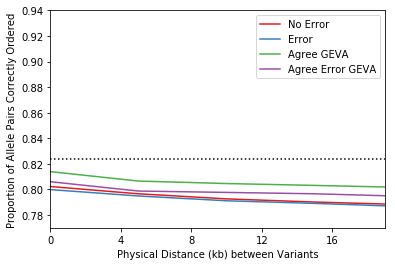

In [57]:
master_dataframe = pd.read_csv("/home/wilderwohns/out_of_africa_fig_transfer/data/GEVA_frequency_distance_accuracy.csv")

plt.plot(range(0,100,5),master_dataframe.Agree/master_dataframe.Total,label="No Error",color="#e41a1c")
plt.plot(range(0,100,5),master_dataframe.AgreeError/master_dataframe.TotalError,label="Error",color="#377eb8")
plt.plot(range(0,100,5),master_dataframe.AgreeGeva/master_dataframe.Total,label="Agree GEVA",color="#4daf4a")
plt.plot(range(0,100,5),master_dataframe.AgreeGevaError/master_dataframe.TotalError,label="Agree Error GEVA",color="#984ea3")
# plt.xlabel("Distance Separating Alleles (bp)")
master_dataframe.to_csv("/home/wilderwohns/geva_comparison/combined_data")
plt.xlabel("Physical Distance (kb) between Variants")
plt.ylabel("Proportion of Allele Pairs Correctly Ordered")
plt.ylim(0.77,0.94)
plt.xlim(0,19)
plt.axhline(y=0.8240836808549863,color="black",linestyle=":")
plt.legend()
plt.xticks(np.arange(0, 20, step=4))

plt.savefig('ooa_plot.eps', format='eps', dpi=1000)
print(sum(master_dataframe.Agree)/sum(master_dataframe.Total))
print(sum(master_dataframe.AgreeError)/sum(master_dataframe.TotalError))
print(sum(master_dataframe.AgreeGeva)/sum(master_dataframe.Total))
print(sum(master_dataframe.AgreeGevaError)/sum(master_dataframe.TotalError))

# Directly comparable reimplementation

0.9163624120903786
0.915131505497838
0.8955395465320491
0.8862762688338661


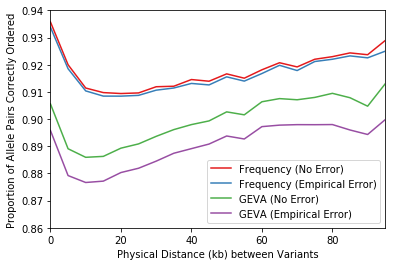

In [92]:
master_dataframe = pd.read_csv("/home/wilderwohns/directly_comparable/data/ancestrally_linked_GEVA_frequency_distance_accuracy.csv")
plt.plot(range(0,100,5),master_dataframe.Agree/master_dataframe.Total,label="Frequency (No Error)",color="#e41a1c")
plt.plot(range(0,100,5),master_dataframe.AgreeError/master_dataframe.TotalError,label="Frequency (Empirical Error)",color="#377eb8")
plt.plot(range(0,100,5),master_dataframe.AgreeGeva/master_dataframe.Total,label="GEVA (No Error)",color="#4daf4a")
plt.plot(range(0,100,5),master_dataframe.AgreeGevaError/master_dataframe.TotalError,label="GEVA (Empirical Error)",color="#984ea3")
# plt.xlabel("Distance Separating Alleles (bp)")

plt.xlabel("Physical Distance (kb) between Variants")
plt.ylabel("Proportion of Allele Pairs Correctly Ordered")
plt.ylim(0.86,0.94)
plt.xlim(0,95)
plt.axhline(y=0.8240836808549863,color="black",linestyle=":")
plt.legend()

plt.savefig('directly_comparable_plot.eps', format='eps', dpi=1000)
print(sum(master_dataframe.Agree)/sum(master_dataframe.Total))
print(sum(master_dataframe.AgreeError)/sum(master_dataframe.TotalError))
print(sum(master_dataframe.AgreeGeva)/sum(master_dataframe.Total))
print(sum(master_dataframe.AgreeGevaError)/sum(master_dataframe.TotalError))

In [7]:
n_bins = 20
bin_size = 100000//n_bins
total = np.zeros(n_bins, dtype=np.int)
agree = np.zeros(n_bins, dtype=np.int)


In [418]:
for i in tqdm(range(1,100)):
    sim=msprime.simulate(sample_size=50,Ne=10000,mutation_rate=1e-8,recombination_rate=1e-8,length=100000)
    tables=sim.dump_tables()
    mutations = list(sim.mutations())
    num_mutations=len(list(sim.mutations()))
    ancestrally_linked_pairs=list()
    for combo in list(itertools.combinations(range(0,num_mutations),2)):
        result1=recursive_search(mutations[combo[0]].node,mutations[combo[0]].node,mutations[combo[1]].node)
        result2=recursive_search(mutations[combo[1]].node,mutations[combo[1]].node,mutations[combo[0]].node)
        if result1 is not None : ancestrally_linked_pairs.append(result1)
        if result2 is not None : ancestrally_linked_pairs.append(result2)
    variants = list(sim.variants())
    nodes = list(sim.nodes())
    mutation_positions=[mutation.position for mutation in list(sim.mutations())]
    
    for combo in ancestrally_linked_pairs:
        
        if (sum(variants[combo[0]].genotypes) != 1 and sum(variants[combo[1]].genotypes) != 1):
            distance = int(abs(mutation_positions[combo[0]] - mutation_positions[combo[1]]))
            total[distance//bin_size] += 1
            if (sum(variants[combo[0]].genotypes) < sum(variants[combo[1]].genotypes)) == (nodes[mutations[combo[0]].node].time < nodes[mutations[combo[1]].node].time):
                agree[distance//bin_size] += 1


HBox(children=(IntProgress(value=0, max=99), HTML(value='')))

KeyboardInterrupt: 

In [421]:
sum(agree)/sum(total)

0.9176318452715619

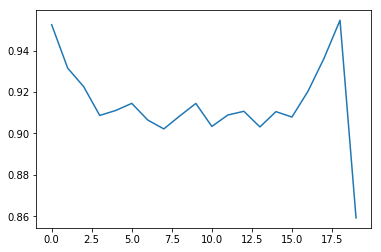

In [420]:
#Without SINGLETONS, don't consider any of the same age, flip coin for same frequency
plt.plot(agree/total)


In [387]:
# for tree in sim.trees():
#     print(display(SVG(tree.draw())))

In [388]:
#list(sim.mutations())

In [390]:
def recursive_search(cur_node,origin_node,target_node):
    for node in tables.edges.parent[tables.edges.child == cur_node]:
        if node == target_node:
            return(mutations[combo[0]].id,mutations[combo[1]].id)
        else:
            return(recursive_search(node,origin_node,target_node))


# Freq distance figure for transfer

0.8312815504017403
0.8306496865706028


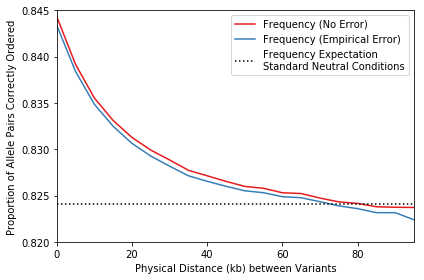

In [8]:
master_dataframe = pd.read_csv("/home/wilderwohns/freq_compare_transfer/data/frequency_distance_accuracy_singletons.csv")
plt.plot(range(0,100,5),master_dataframe.Agree/master_dataframe.Total,label="Frequency (No Error)",color="#e41a1c")
plt.plot(range(0,100,5),master_dataframe.ErrorAgree/master_dataframe.TotalError,label="Frequency (Empirical Error)",color="#377eb8")

plt.ylim(0.82,0.845)
plt.xlim(0,95)
plt.axhline(y=0.8240836808549863,color="black",linestyle=":",label="Frequency Expectation\nStandard Neutral Conditions")
plt.xlabel("Physical Distance (kb) between Variants")
plt.ylabel("Proportion of Allele Pairs Correctly Ordered")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
lgd = plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('frequency_distance_100k_replicates.eps', format='eps', dpi=1000, bbox_extra_artists=(lgd,xlabel,ylabel), bbox_inches='tight')
print(sum(master_dataframe.Agree)/sum(master_dataframe.Total))
print(sum(master_dataframe.ErrorAgree)/sum(master_dataframe.TotalError))


In [5]:
master_dataframe

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Agree,ErrorAgree,SeparationDistanceEnd,SeparationDistanceStart,Total,TotalError
0,0,0,0,0,75867486.0,75704162.0,4999,0,89854413.0,89760182.0
1,1,1,1,1,71835064.0,71694579.0,9999,5000,85602289.0,85513522.0
2,2,2,2,2,67742402.0,67614185.0,14999,10000,81077060.0,80988534.0
3,3,3,3,3,63729888.0,63606109.0,19999,15000,76496958.0,76405927.0
4,4,4,4,4,59801782.0,59669672.0,24999,20000,71940298.0,71836511.0
5,5,5,5,5,55865338.0,55725923.0,29999,25000,67315343.0,67199514.0
6,6,6,6,6,51967513.0,51830072.0,34999,30000,62699170.0,62584151.0
7,7,7,7,7,48047856.0,47926506.0,39999,35000,58048344.0,57943195.0
8,8,8,8,8,44191241.0,44085324.0,44999,40000,53427394.0,53337855.0
9,9,9,9,9,40305015.0,40219395.0,49999,45000,48764382.0,48692106.0
